In [1]:
import os, sys, subprocess, pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
sys.path.insert(0, '/asap3/petra3/gpfs/common/p21.2/scripts/')
import py3DXRD
import experiment_settings
single_separator = "--------------------------------------------------------------"
double_separator = "=============================================================="

### SETTING GLOBAL VARIABLES - DIRECTORY ROOT AND MATERIAL:
path_gen = '/asap3/petra3/gpfs/p21.2/2022/data/11012680/'
materials_table = {'Au'  : {'name': 'Au'  , 'spacegroup': 225, 'symmetry':'F', 'unitcell': [4.0720, 4.0720,  4.0720, 90., 90.,  90.]},
                   'CeO2': {'name': 'CeO2', 'spacegroup': 225, 'symmetry':'F', 'unitcell': [5.4115, 5.4115,  5.4115, 90., 90.,  90.]},
                   'Cu'  : {'name': 'Cu'  , 'spacegroup': 225, 'symmetry':'F', 'unitcell': [3.5942, 3.5942,  3.5942, 90., 90.,  90.]},
                   'LaB6': {'name': 'LaB6', 'spacegroup': 221, 'symmetry':'P', 'unitcell': [4.1568, 4.1568,  4.1568, 90., 90.,  90.]},
                   'MgCa': {'name': 'MgCa', 'spacegroup': 194, 'symmetry':'P', 'unitcell': [3.1980, 3.1980,  5.1900, 90., 90., 120.]},
                   'Nb'  : {'name': 'Nb'  , 'spacegroup': 229, 'symmetry':'I', 'unitcell': [3.3042, 3.3042,  3.3042, 90., 90.,  90.]},
                   'Ni'  : {'name': 'Ni'  , 'spacegroup': 225, 'symmetry':'F', 'unitcell': [3.5100, 3.5100,  3.5100, 90., 90.,  90.]},
                   'Pd'  : {'name': 'Pd'  , 'spacegroup': 225, 'symmetry':'F', 'unitcell': [3.8907, 3.8907,  3.8907, 90., 90.,  90.]},
                   'Ruby': {'name': 'Ruby', 'spacegroup': 167, 'symmetry':'R', 'unitcell': [4.7608, 4.7608, 12.9957, 90., 90., 120.]},
                   'Ti'  : {'name': 'Ti'  , 'spacegroup': 194, 'symmetry':'P', 'unitcell': [2.9505, 2.9505,  4.6826, 90., 90., 120.]}}

material = materials_table['MgCa']


### SETTING THE GEOMETRY, SWEEPSCANS PARAMETERS, AND OTHER OBJECTS:
def set_Geometry(path_gen, det_num, material):
    GM = py3DXRD.Geometry() # initialization
    GM.load_par(directory = path_gen + 'processed/', par_file = f'lab6_avg_config_d4.par') # load calibrated parameters
    GM.spline_file = None # Either None for perfect detector, or path to spline file
    GM.set_attr('spacegroup' , material['spacegroup'])
    GM.set_attr('symmetry'   , material['symmetry'  ])
    GM.set_attr('unitcell'   , material['unitcell'  ])
    return GM


def set_SweepProcessor(path_gen, i_load, i_slow, i_fast, det_num):
    default_xyz = [0,0,6.015]
    meta_key = path_gen + f'raw/newMgAl102/{i_load}/{i_load}.log'
#     y_points = np.linspace(-3.5, 3.5, 71) # y-motor positions if needed
#     meta_key = path_gen + f'raw/polypd002/{i_load}/{i_fast:03d}_y1_{y_points[i_fast]:.4f}.fio' # metadata of the sweep
#     meta_key = path_gen + f'raw/fio/eh3scan_00029.fio'
    
    SP = experiment_settings.set_p212_sweep(path_gen, i_slow, i_fast, det_num, default_xyz, meta_key) # this function usually don't need modifications
    
    if SP.sweep['stem'][-1] != '_': SP.sweep['stem'] += '_' # correct for possible mismatch between file stems in the sweep command and actual file names
    SP.processing['options'] = None # ('flip', 'r270') # detector flips if needed to be applied before those in geometry file
    SP.directory = SP.directory.replace('/newMgAl102/', '/Anatoly/newMgAl102/') # if needed to modify the output directory (ie when the default one must not be overwritten)
    return SP


def set_GrainSpotter(path_gen, material):
    GS = experiment_settings.set_grainspotter(path_gen, material, domega=None)
#     GS.load_ini(ini_file = 'example.ini')

    GS.set_attr('tth_ranges'   , [ [4.7, 9.4] ] ) # 12.7]])
    GS.set_attr('ds_ranges'    , [] ) # [0.5, 1.0]]) # GV.ds_ranges)
    GS.set_attr('eta_ranges'   , [ [0, 360]] ) # GV.eta_ranges)
    GS.set_attr('omega_ranges' , [ [-104,  55]] ) # GV.omega_ranges)
    GS.set_attr('cuts'         , [ 12, 0.8,  0.8] )
    GS.set_attr('uncertainties', [0.2, 0.5,  0.5] ) # [sigma_tth sigma_eta sigma_omega] in degrees
    GS.set_attr('nsigmas'      , 1)
    GS.set_attr('eulerstep'    , 6)
    GS.set_attr('Nhkls_in_indexing', None)
    GS.set_attr('random', 10000)
    GS.set_attr('positionfit', True)
    return GS


def set_PolySim(path_gen, grainspotter = None, material = None):
#     PS = py3DXRD.PolySim(directory = path_gen + "")
#     PS.load_inp(inp_file = "")
    PS = experiment_settings.set_polyxsim(grainspotter, material)
    PS.set_attr('inp_file', grainspotter.log_file.strip('.log'))
    PS.set_attr('beamflux', 1e12)
    PS.set_attr('beampol_factor', 1)
    PS.set_attr('beampol_direct', 0)
    PS.set_attr('stem'  , grainspotter.log_file.replace('.log', '_sim'))
    PS.set_attr('grains', [])
    PS.set_attr('omega_start', grainspotter.omega_ranges[0][0])
    PS.set_attr('omega_step' , abs(grainspotter.domega))
    PS.set_attr('omega_end'  , grainspotter.omega_ranges[-1][1])
    PS.set_attr('theta_min'  , grainspotter.tth_ranges[0][0]/2)
    PS.set_attr('theta_max'  , grainspotter.tth_ranges[-1][1]/2)
    PS.set_attr('no_grains'  , 1)
    PS.set_attr('gen_U'   , 0)
    PS.set_attr('gen_pos' , [0, 0])
    PS.set_attr('gen_eps' , [1, 0, 0 ,0, 0])
    PS.set_attr('gen_size', [0.0, 0.0, 0.0 ,0.0])
    PS.set_attr('make_image', 0)
    PS.set_attr('output', ['.tif', '.par', '.gve'])
    PS.set_attr('bg' , 0)
    PS.set_attr('psf', 0.7)
    PS.set_attr('peakshape', [1, 4, 0.5])
    return PS


def set_DATA(path_gen, i_load, i_slow, i_fast, detectors, material):
    yml_det_order = [1] # [4,1,2,3]
    DATA = py3DXRD.DataAnalysis()
    DATA.set_attr('material', material)
    for det_num in detectors:
        SP = set_SweepProcessor(path_gen, i_load, i_slow, i_fast, det_num)
        GM = set_Geometry(path_gen, det_num, material)
        SP.set_attr('geometry', GM)
        DATA.add_to_attr('sweepProcessors', SP)
    DATA.set_attr('yml_det_order', yml_det_order)
    DATA.set_attr('directory'    , SP.directory)
    DATA.set_attr('name'         , f's{i_slow:03d}_f{i_fast:03d}_'+material['name'])
    DATA.set_attr('position'     , SP.position)
    DATA.set_attr('rotation'     , [0,0,0])
    if SP.log_meta:
        load_values = [ent['load'] for ent in SP.log_meta['entries']]
        DATA.set_attr('pressure', sum(load_values) / len(load_values))
    return DATA

--------------------------------------------------------------
SETTINGS LOADED!


LOAD = 1892, TRANSLATIONS: slow = 0, fast = 2
Initialized DataAnalysis object.
--------------------------------------------------------------
Reading p212 log file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/raw/newMgAl102/1892/1892.log
file = 1892.log
directory = /asap3/petra3/gpfs/p21.2/2022/data/11012680/raw/newMgAl102/1892/
data_and_time = 2022-05-28 15:27:26
crosshead_position = -10.0075
command = sweepwrap 75.50 235.50 640 0.10 newMgAl102 ['--superz', '6.015', '6.765', '6']
det_num = 4
pressure = 1.1311000000000004
In total 1000 log entries with keys:
['timestamp', 'petra', 'oh_diode', 'eh_diode', 'beamstop', 'loadcell', 'load']
--------------------------------------------------------------
Reading p212 fio file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/raw/newMgAl102/1892/1892_y_0.000_z_6.315.fio
file = 1892_y_0.000_z_6.315.fio
directory = /asap3/petra3/gpfs/p21.2/2022/data/11012680/raw/newMgAl102/1892/
detectors = [1]
command = fastsweep idrz1 75.5 235.5 1:640/0.100,fdir="/

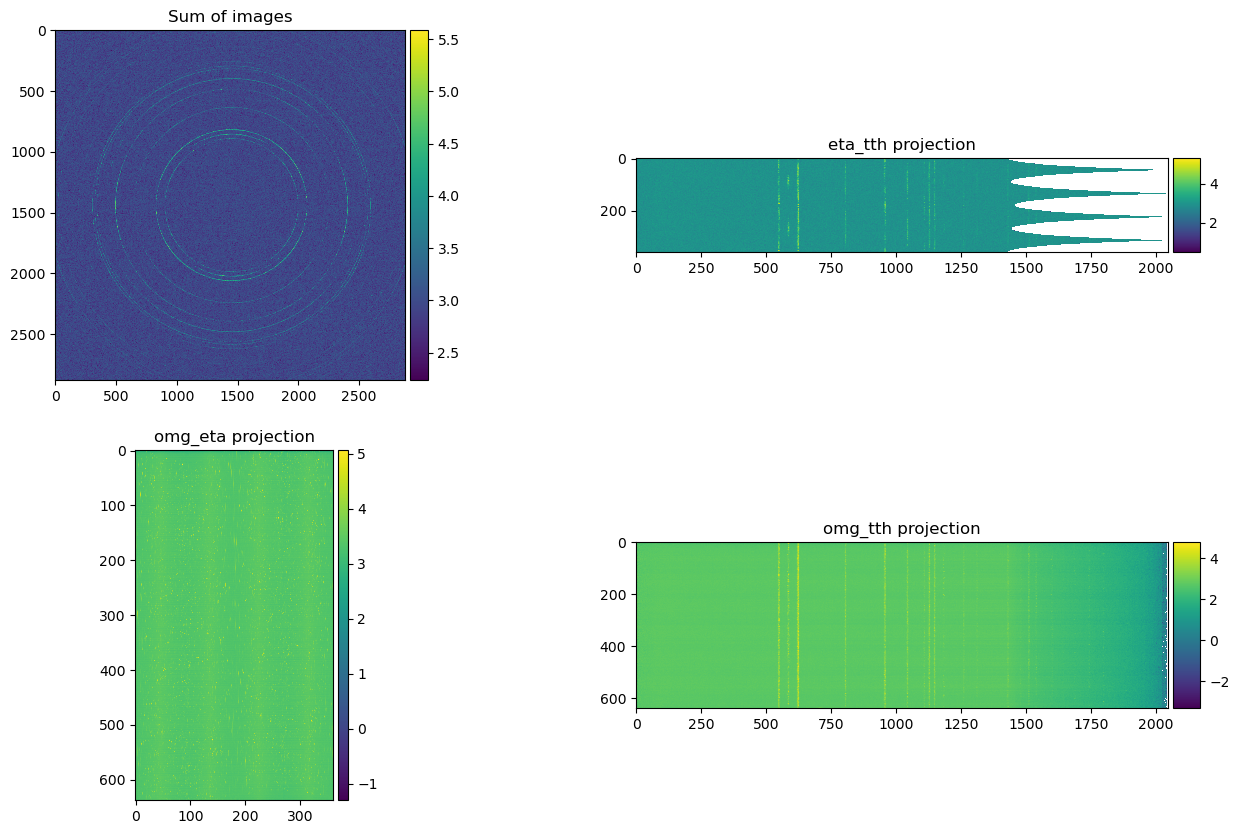

Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4_projs.png
Exporting data as: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4_t83.npz
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4_bckg.tif
Deleted old files.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/projs_ranges/s000_f002_d4_proj_immax.tif
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/projs_ranges/s000_f002_d4_proj_imsum.tif
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/projs_ranges/s000_f002_d4_proj_etatth.tif
Writing file: /as

Last line in the output:55.375 -103.875
Exported all the geometries as .yml file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_MgCa.yml
--------------------------------------------------------------

INDEXING of s000_f002_d4:
Initialized PeakIndexer object.
Reading file:/asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4.flt
25720 peaks loaded.
Generated PeakIndexer in /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/ named s000_f002_d4
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4.par
File already exist!
Overwriting...
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4.yml
File already exist!
Overwriting...
Running indexer on: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatol

55.375 -103.875
Resulted gvectors saved in: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4_MgCa.gve
Initialized GvectorEvaluator object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_d4_MgCa.gve
25720 gvectors loaded.
Generated GvectorEvaluator in /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/ named s000_f002_d4_MgCa
--------------------------------------------------------------

EVALUATING GVECTORS for s000_f002_MgCa:
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/temp.gve
Got wavelength from gv file of  0.238431
Got wedge from gv file of  0.0
Got wavelength from gv file of  0.238431
Got wedge from gv file of  0.0

Got 1 sets of omega values from gv file:
- Range 1 from -104 to   55 ==> 159 degrees
Read your gv file containing (25720, 3)
Assign to 

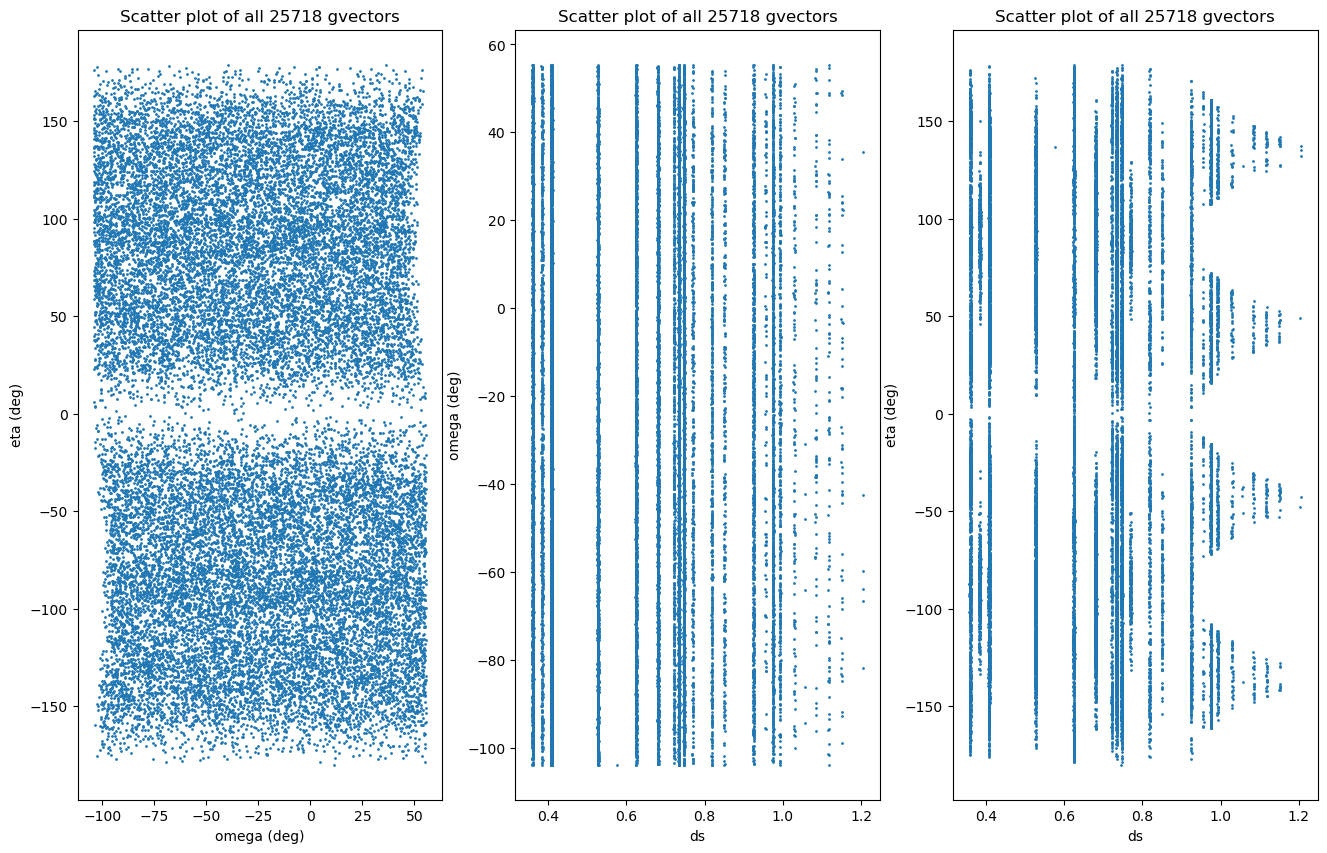

Saved projections: s000_f002_MgCa_scatter.png
ds, n_peaks:  0.193, 0
ds, n_peaks:  0.361, 2202
ds, n_peaks:  0.385, 870
ds, n_peaks:  0.409, 4718
ds, n_peaks:  0.528, 2600
ds, n_peaks:  0.578, 0
ds, n_peaks:  0.625, 2034
ds, n_peaks:  0.654, 0
ds, n_peaks:  0.682, 2774
ds, n_peaks:  0.722, 697
ds, n_peaks:  0.735, 2866
ds, n_peaks:  0.747, 2569
ds, n_peaks:  0.771, 401
ds, n_peaks:  0.819, 564
ds, n_peaks:  0.851, 305
ds, n_peaks:  0.925, 932
ds, n_peaks:  0.955, 111
ds, n_peaks:  0.963, 0
ds, n_peaks:  0.975, 1167
ds, n_peaks:  0.993, 470
ds, n_peaks:  1.029, 138
ds, n_peaks:  1.056, 6
ds, n_peaks:  1.083, 90
ds, n_peaks:  1.100, 0
ds, n_peaks:  1.117, 97
ds, n_peaks:  1.149, 55
ds, n_peaks:  1.156, 1
ds, n_peaks:  1.204, 6


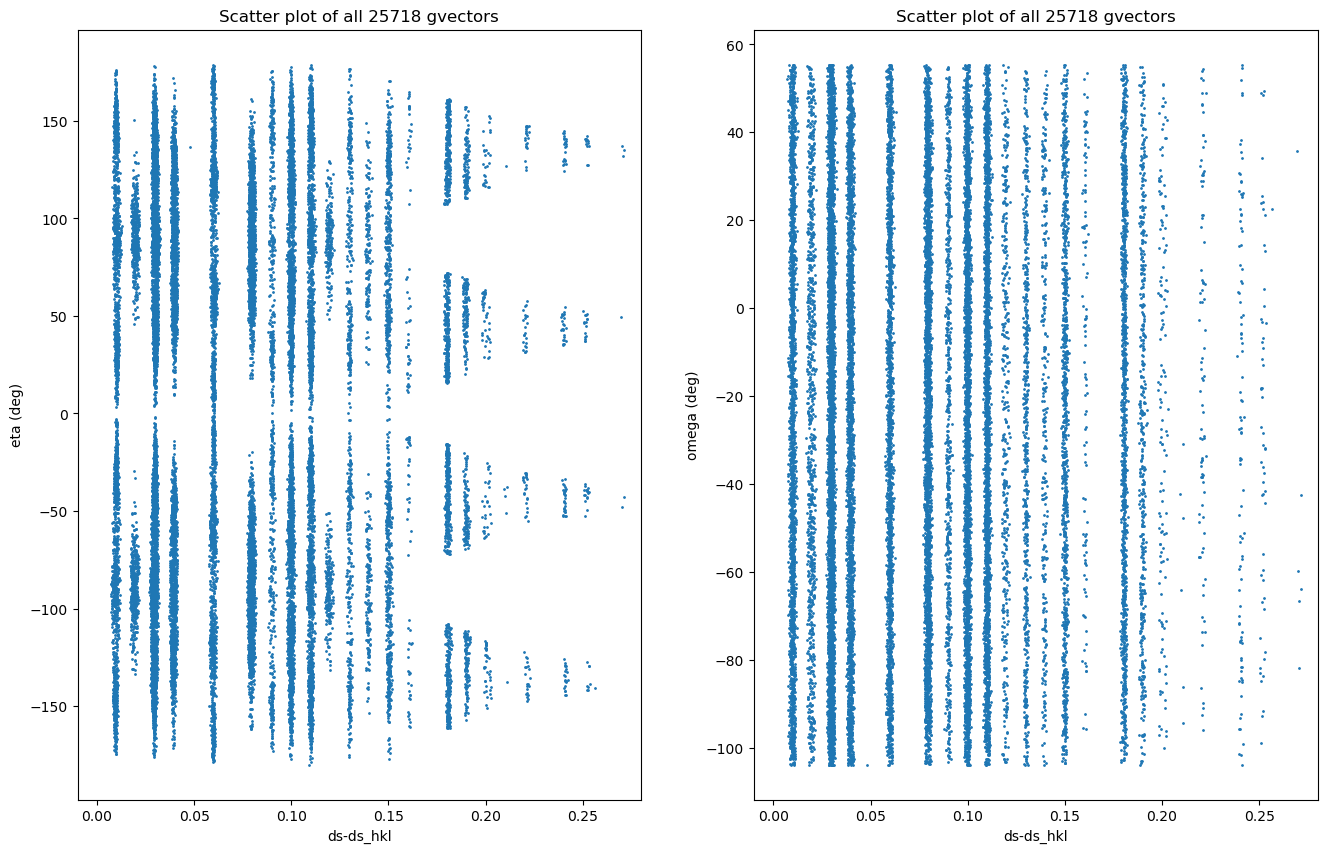

Saved eta_delta_ds: s000_f002_MgCa_scatter_eta_delta_ds.png
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_MgCa.gve
File already exist!
Overwriting...
Initialized GrainSpotter object.
--------------------------------------------------------------

RUNNING GRAINSPOTTER for s000_f002_MgCa
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_MgCa.ini
File already exist!
Overwriting...
Running grainspotter on: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_MgCa.gve
Using ini_file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_MgCa.ini
Last line in the output:Elapsed time: 10.90 sec = 0.18 min
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_MgCa.log
Initialized Grain object.


rm: cannot remove ‘/asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim*’: No such file or directory


Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/
par_file: s000_f002_d4.par
yml_file: s000_f002_d4.yml
poni_file: s000_f002_d4.poni
flt_file: None
gve_file: None
unitcell: [3.198, 3.198, 5.19, 90.0, 90.0, 120.0]
symmetry: P
spacegroup: 194
chi: 0.0
distance: 953080.0
buffer: None
saturation_level: None
fit_tolerance: 0.5
min_bin_prob: 1e-05
no_bins: 10000
O:  [[0, -1], [1, 0]]
omegasign: 1
t: [0.0, 0.0, 0.0]
tilt: [-0.0, 0.00037, 0.002296]
wedge: 0.0
weight_hist_intensities: 0
wavelength: 0.238431
y_center: 1452.473
y_size: 150.0
dety_size: 2880
z_center: 1441.215
z_size: 150.0
detz_size: 2880
spline_file: None
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.00

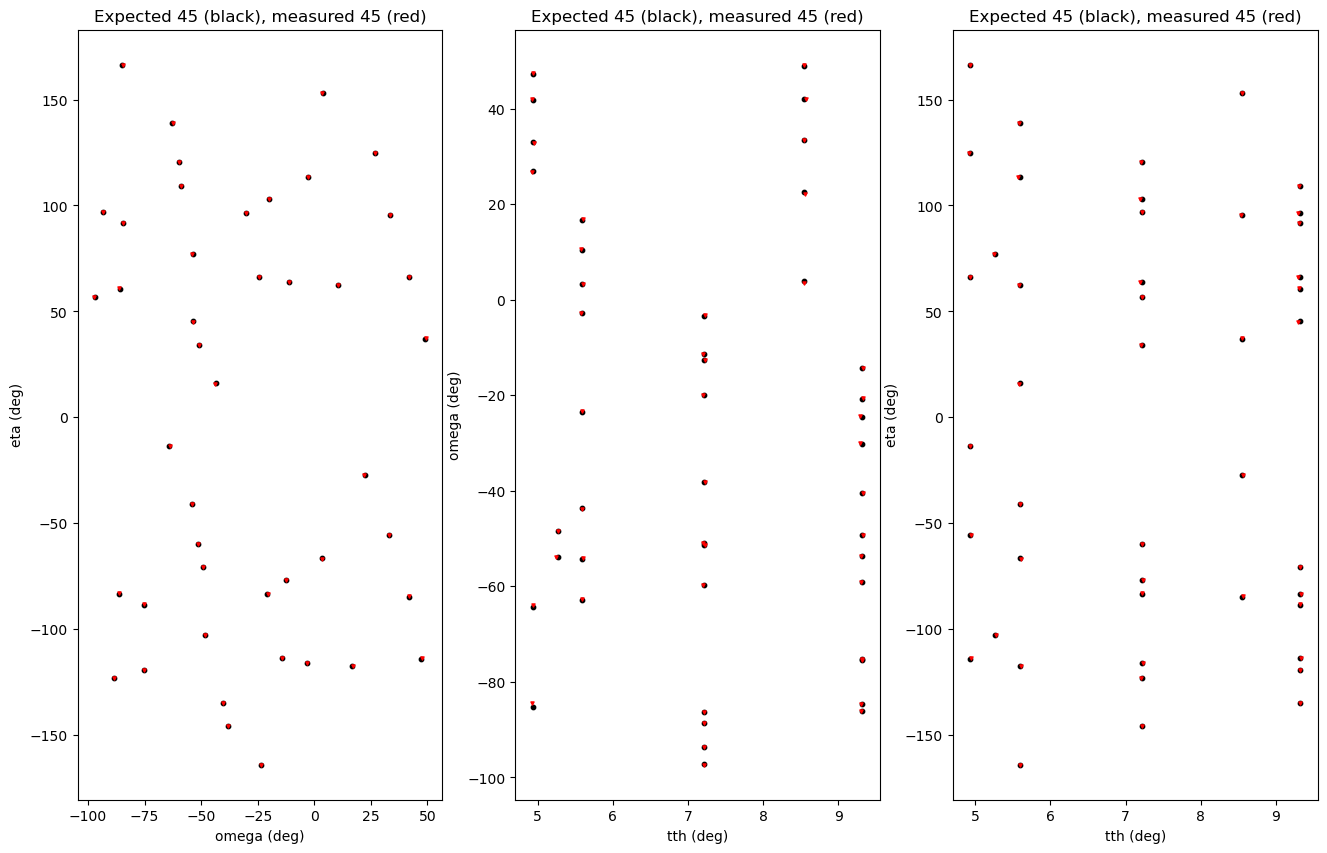

Saved measured vs expected: s000_f002_MgCa_g1_scatter.png
--------------------------------------------------------------

GRAIN 2
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g002_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g002_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g002_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f002

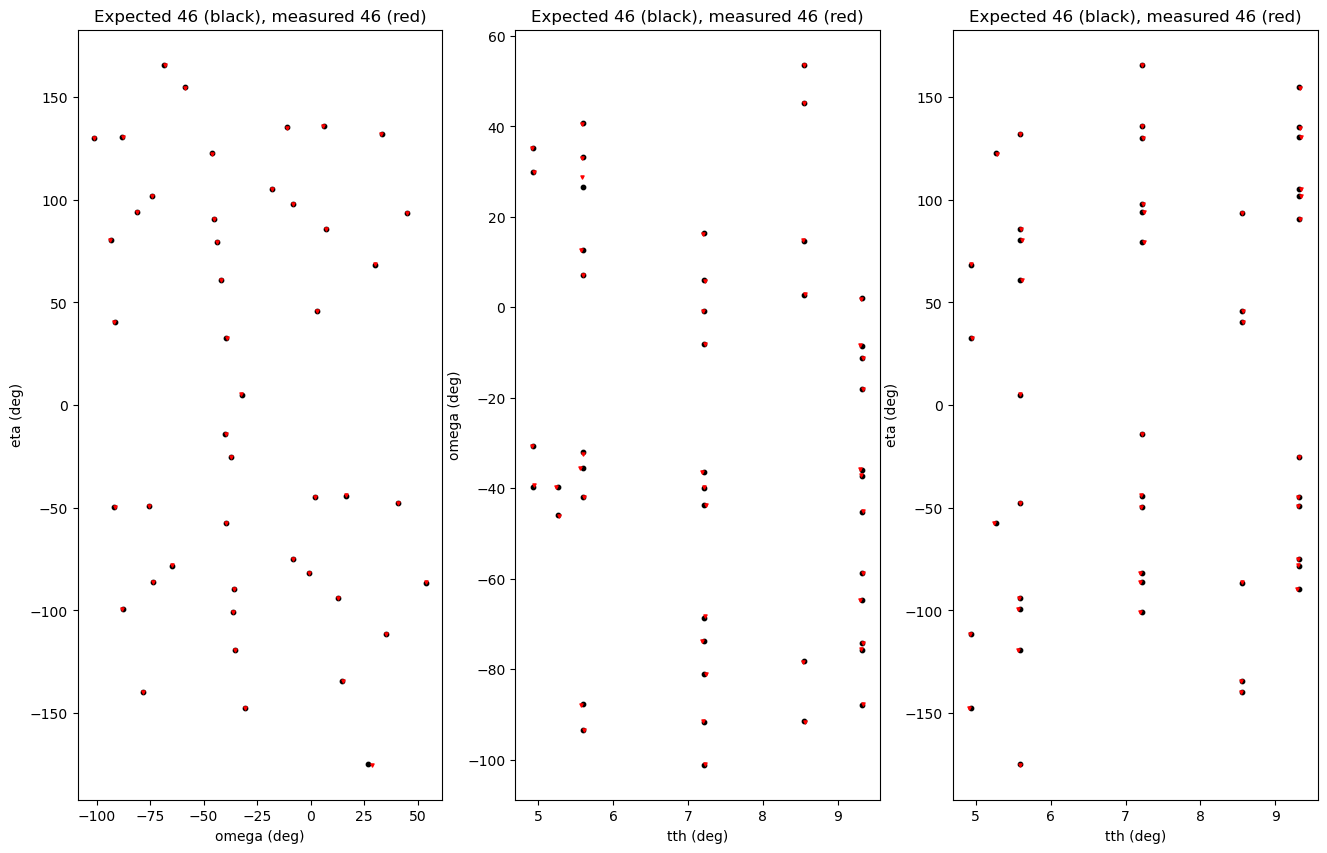

Saved measured vs expected: s000_f002_MgCa_g2_scatter.png
--------------------------------------------------------------

GRAIN 3
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g003_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g003_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g003_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f002

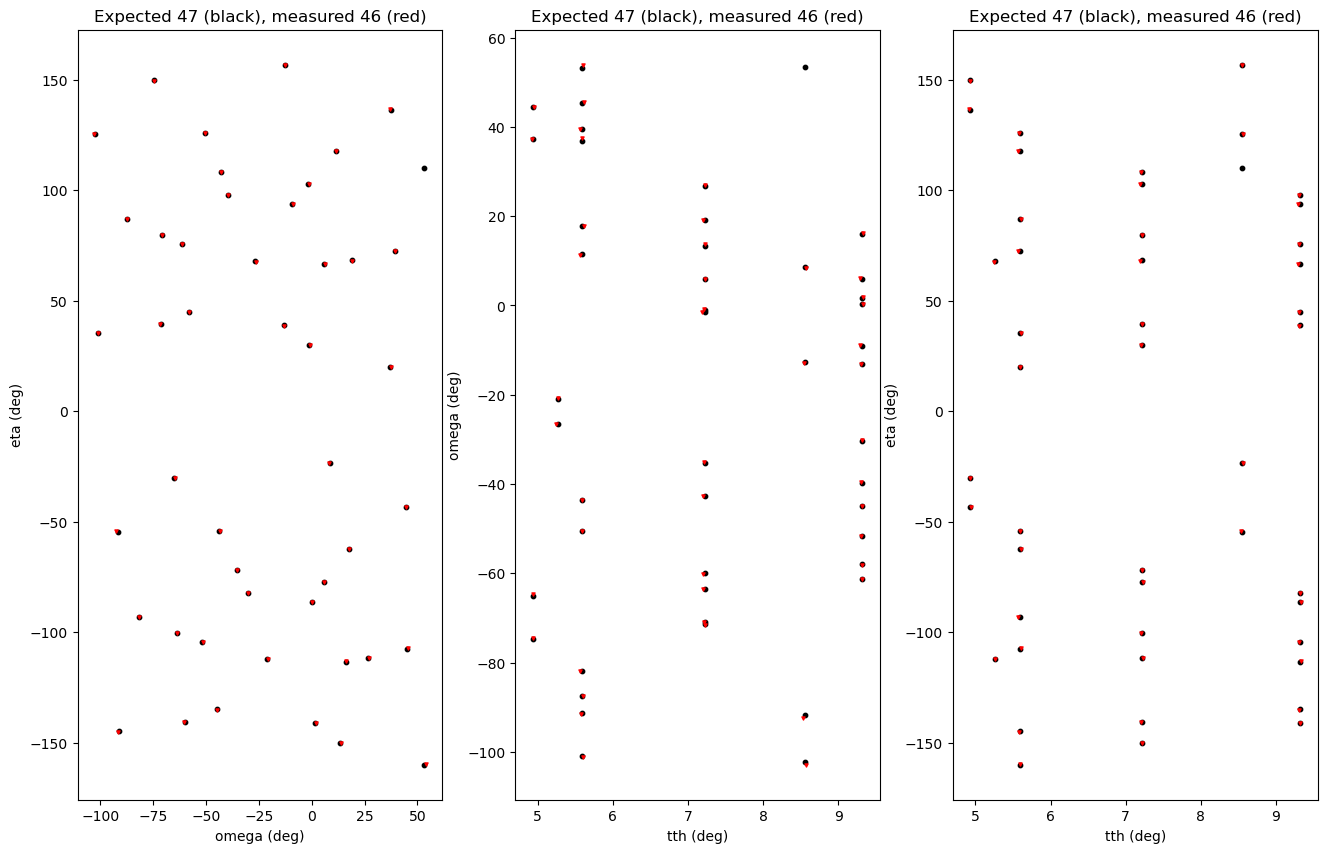

Saved measured vs expected: s000_f002_MgCa_g3_scatter.png
--------------------------------------------------------------

GRAIN 4
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g004_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g004_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g004_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f002

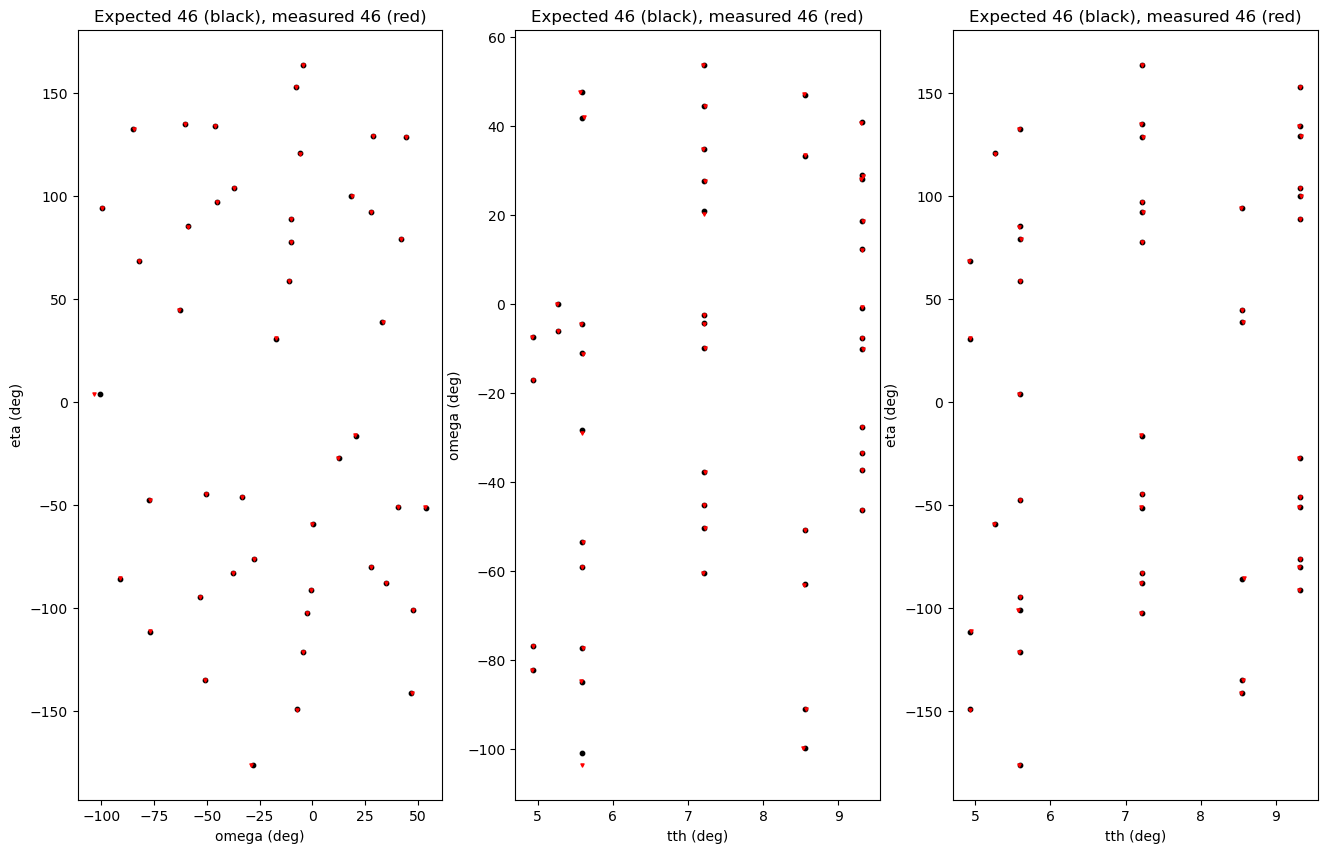

Saved measured vs expected: s000_f002_MgCa_g4_scatter.png
--------------------------------------------------------------

GRAIN 5
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g005_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g005_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g005_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f002

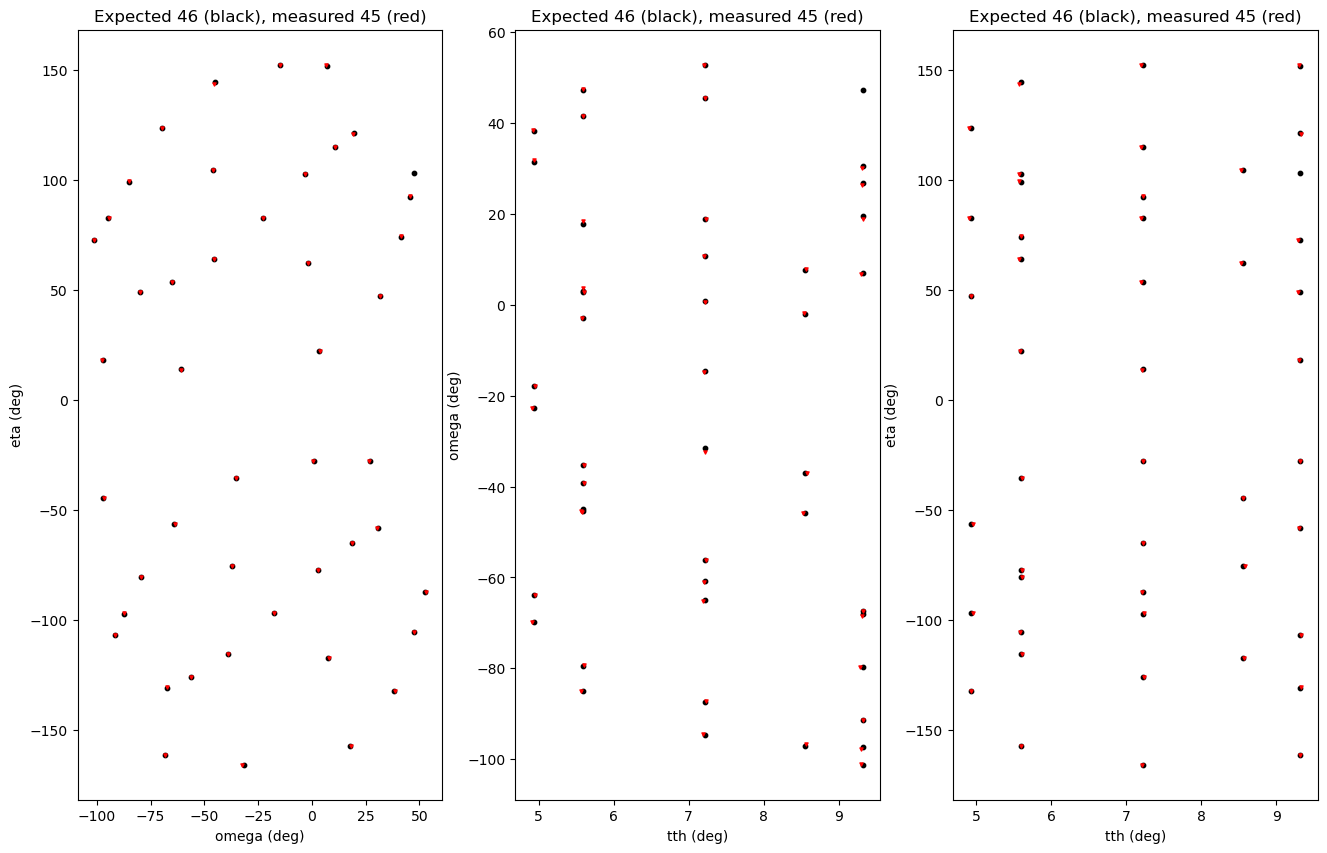

Saved measured vs expected: s000_f002_MgCa_g5_scatter.png
--------------------------------------------------------------

GRAIN 6
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g006_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g006_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g006_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f002

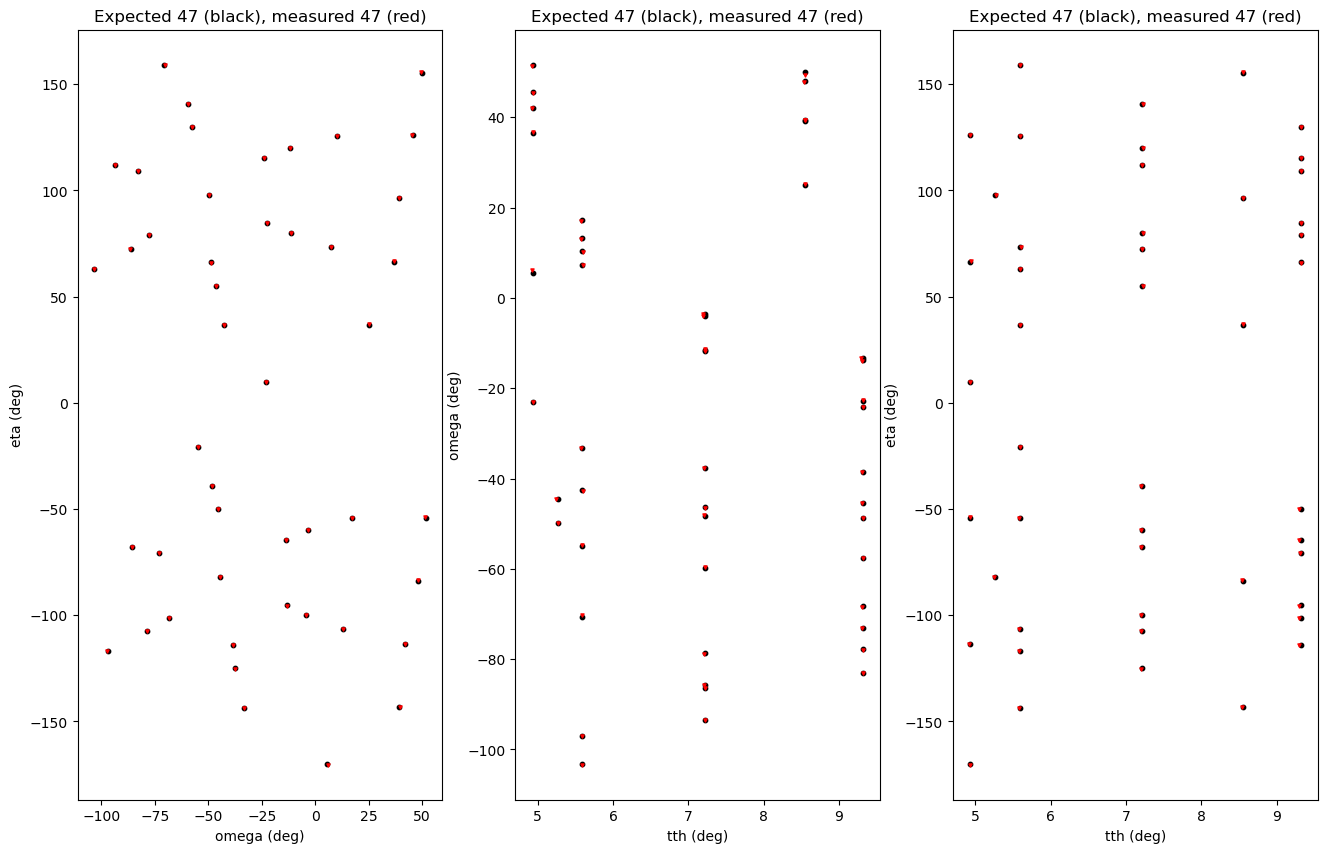

Saved measured vs expected: s000_f002_MgCa_g6_scatter.png
--------------------------------------------------------------

GRAIN 7
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g007_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g007_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g007_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f002

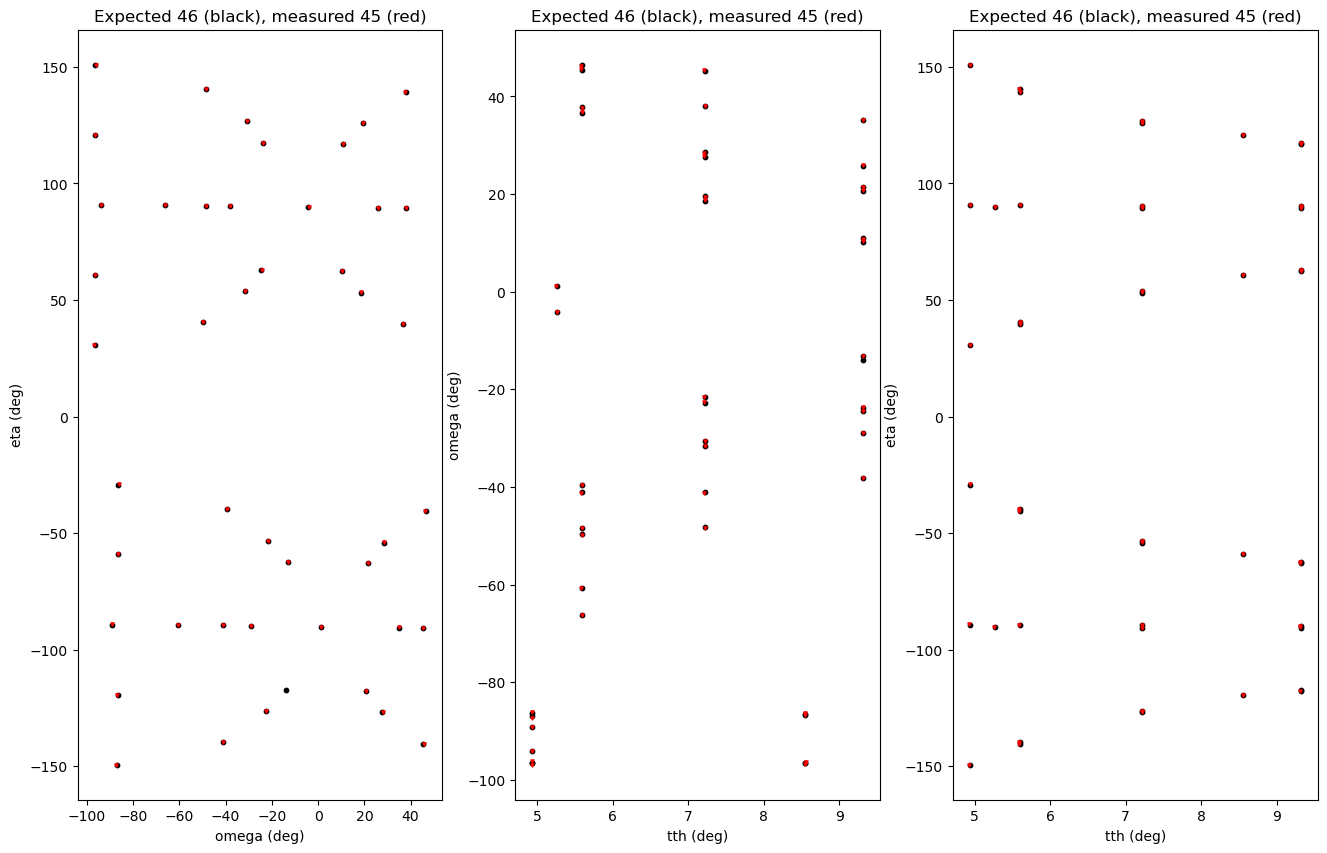

Saved measured vs expected: s000_f002_MgCa_g7_scatter.png
--------------------------------------------------------------

GRAIN 8
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g008_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g008_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g008_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f002

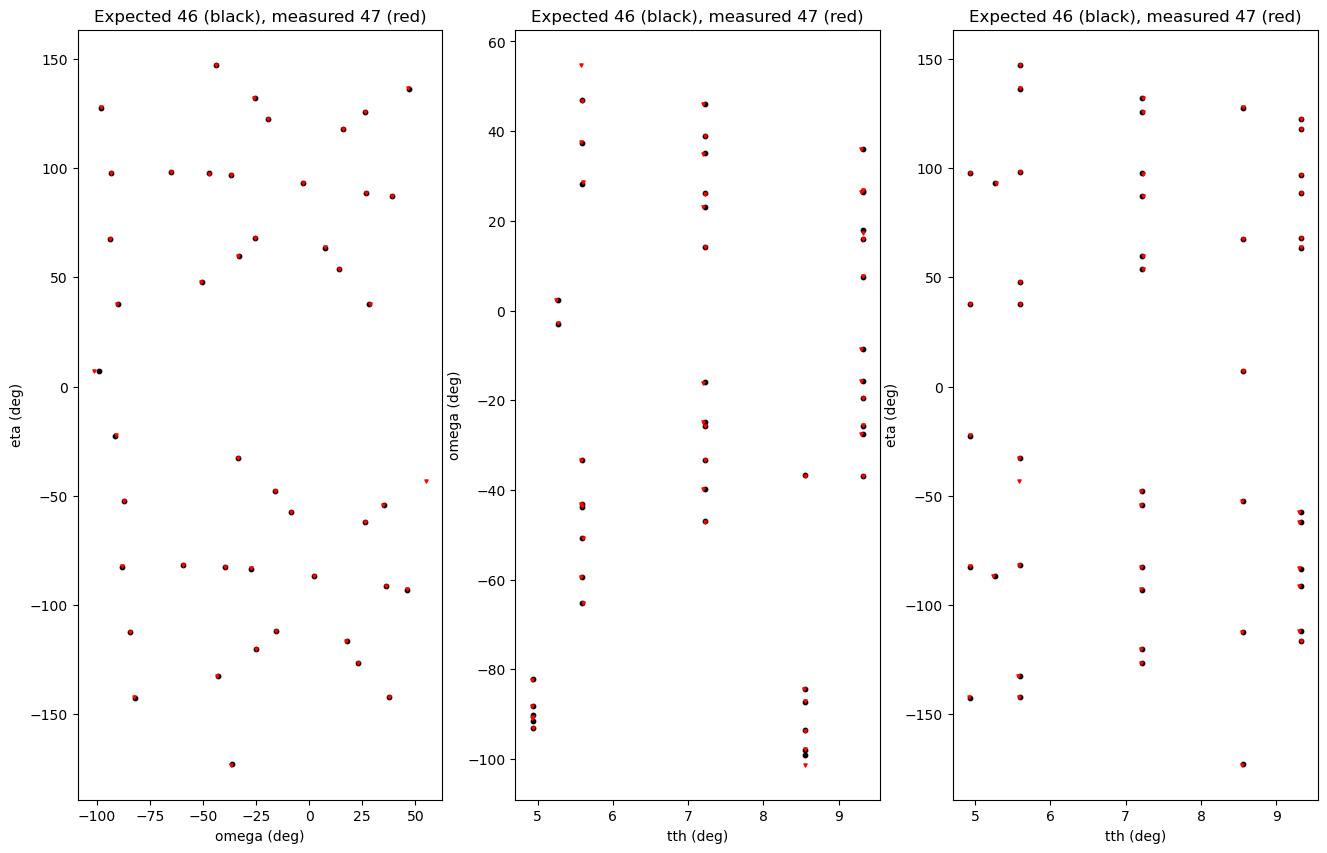

Saved measured vs expected: s000_f002_MgCa_g8_scatter.png
--------------------------------------------------------------

GRAIN 9
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g009_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g009_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g009_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f002

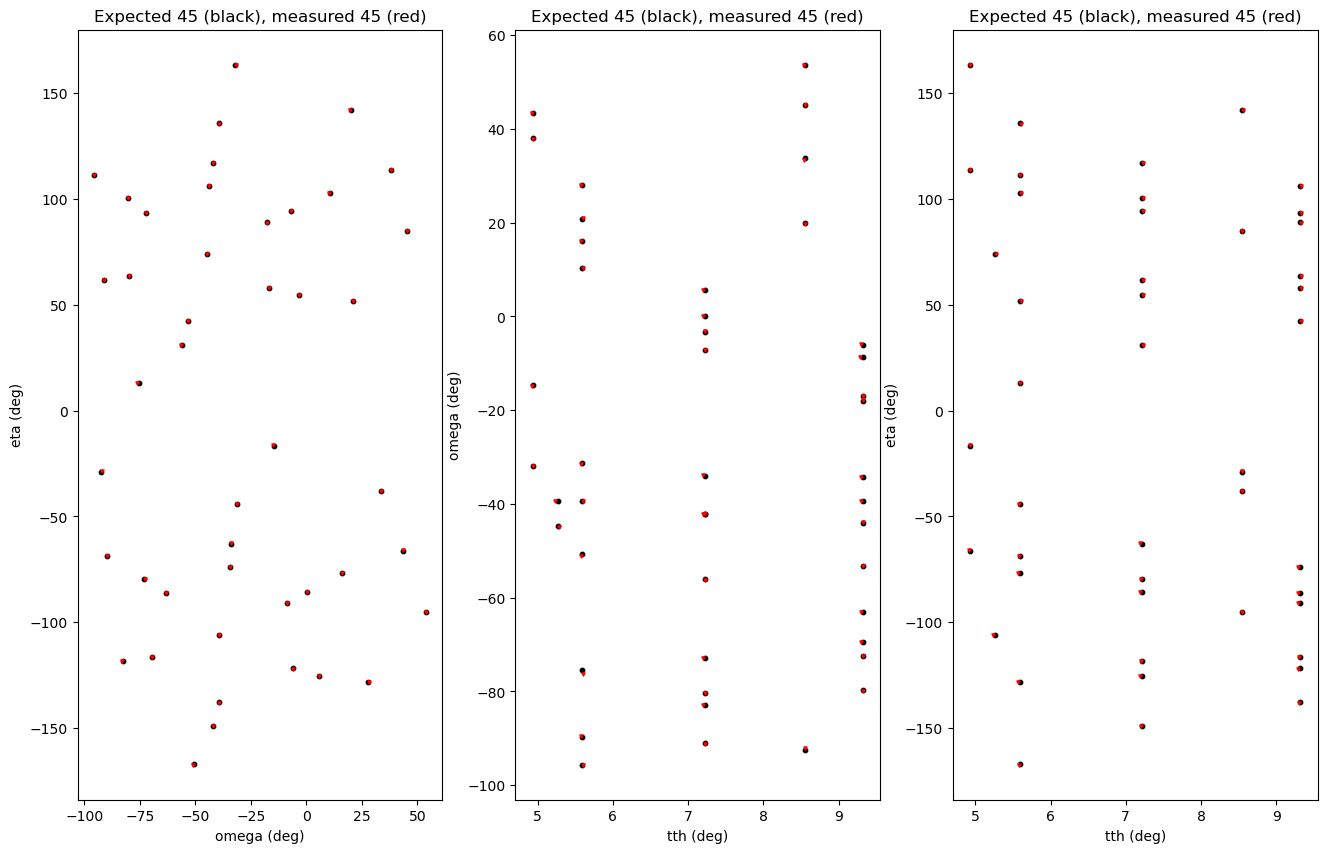

Saved measured vs expected: s000_f002_MgCa_g9_scatter.png
--------------------------------------------------------------

GRAIN 10
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g010_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g010_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g010_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f00

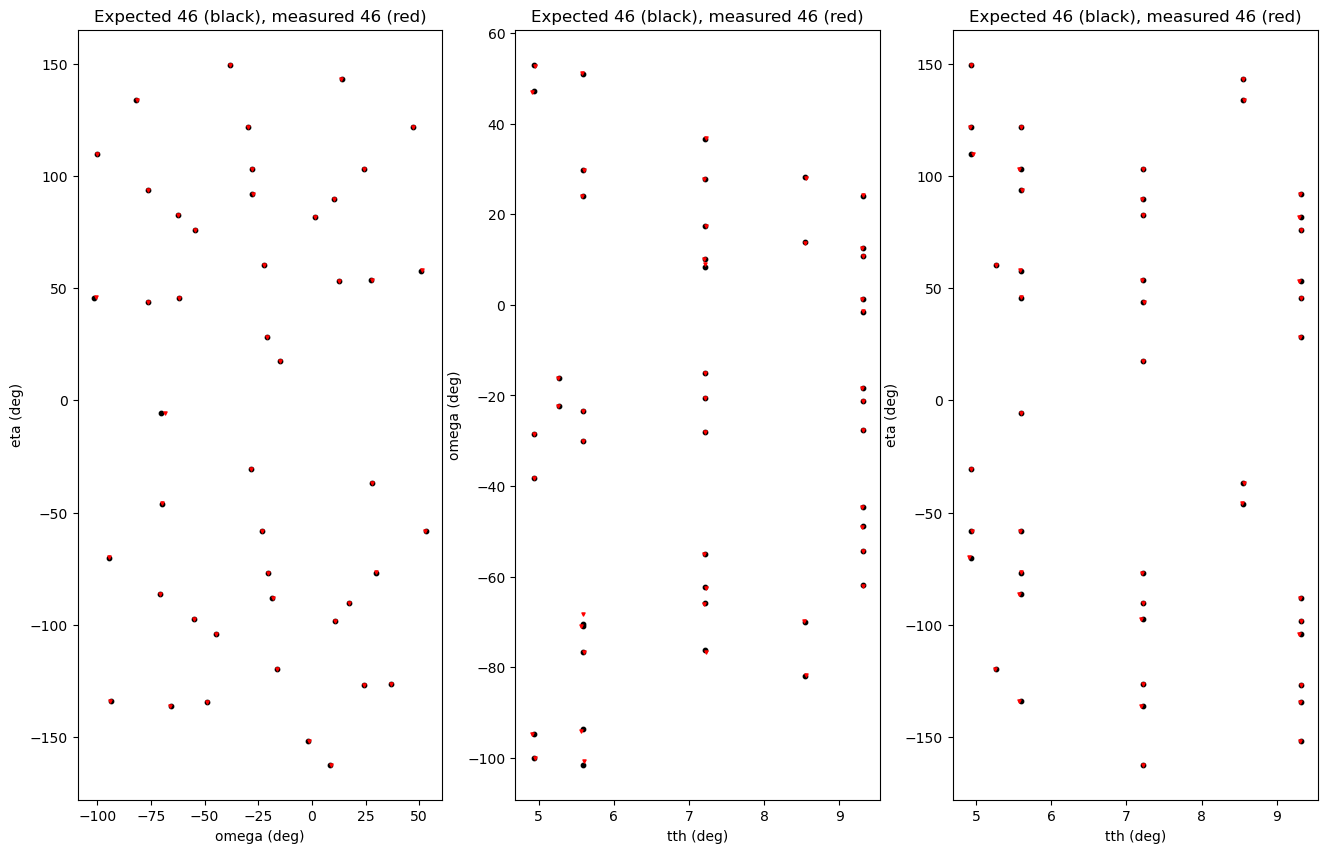

Saved measured vs expected: s000_f002_MgCa_g10_scatter.png
--------------------------------------------------------------

GRAIN 11
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g011_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g011_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g011_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

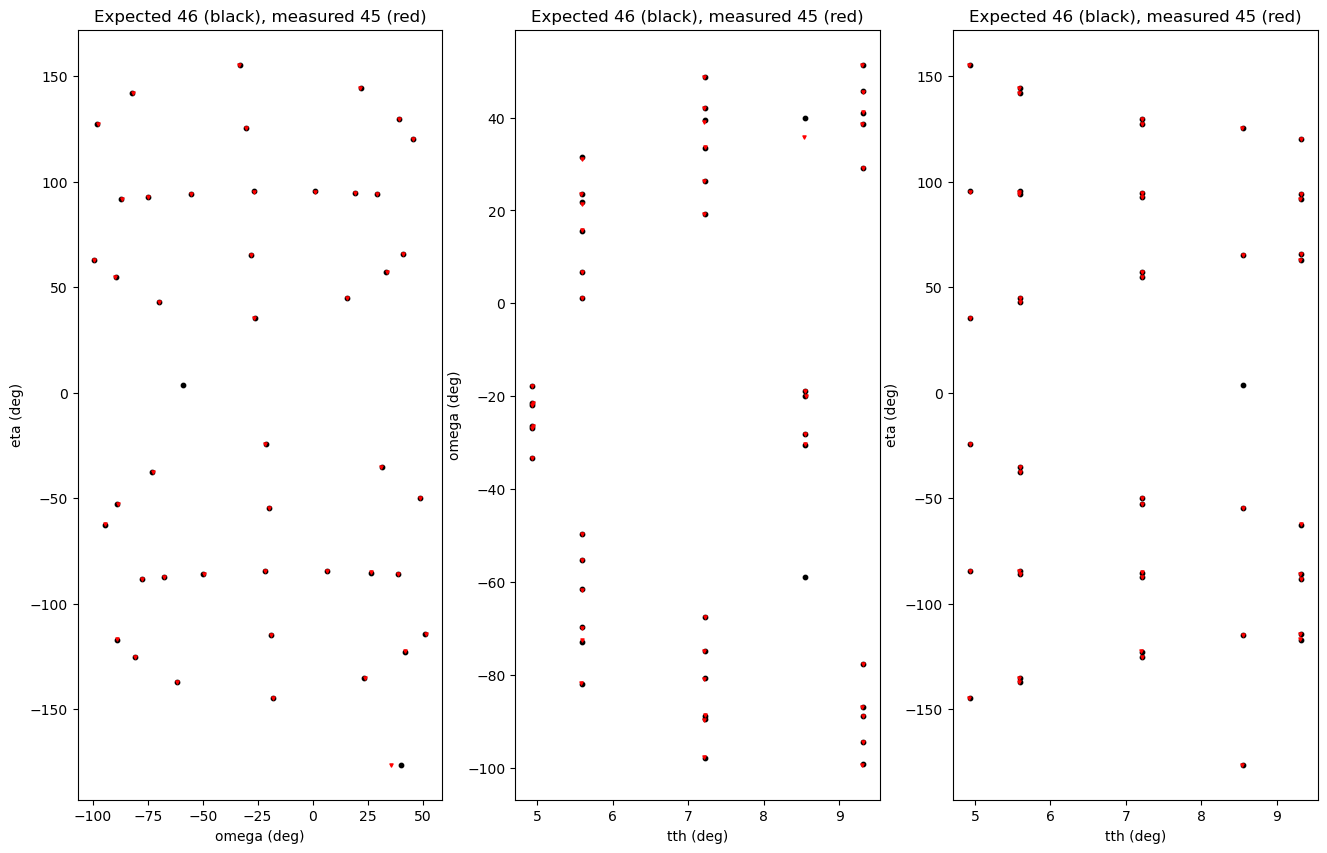

Saved measured vs expected: s000_f002_MgCa_g11_scatter.png
--------------------------------------------------------------

GRAIN 12
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g012_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g012_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g012_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

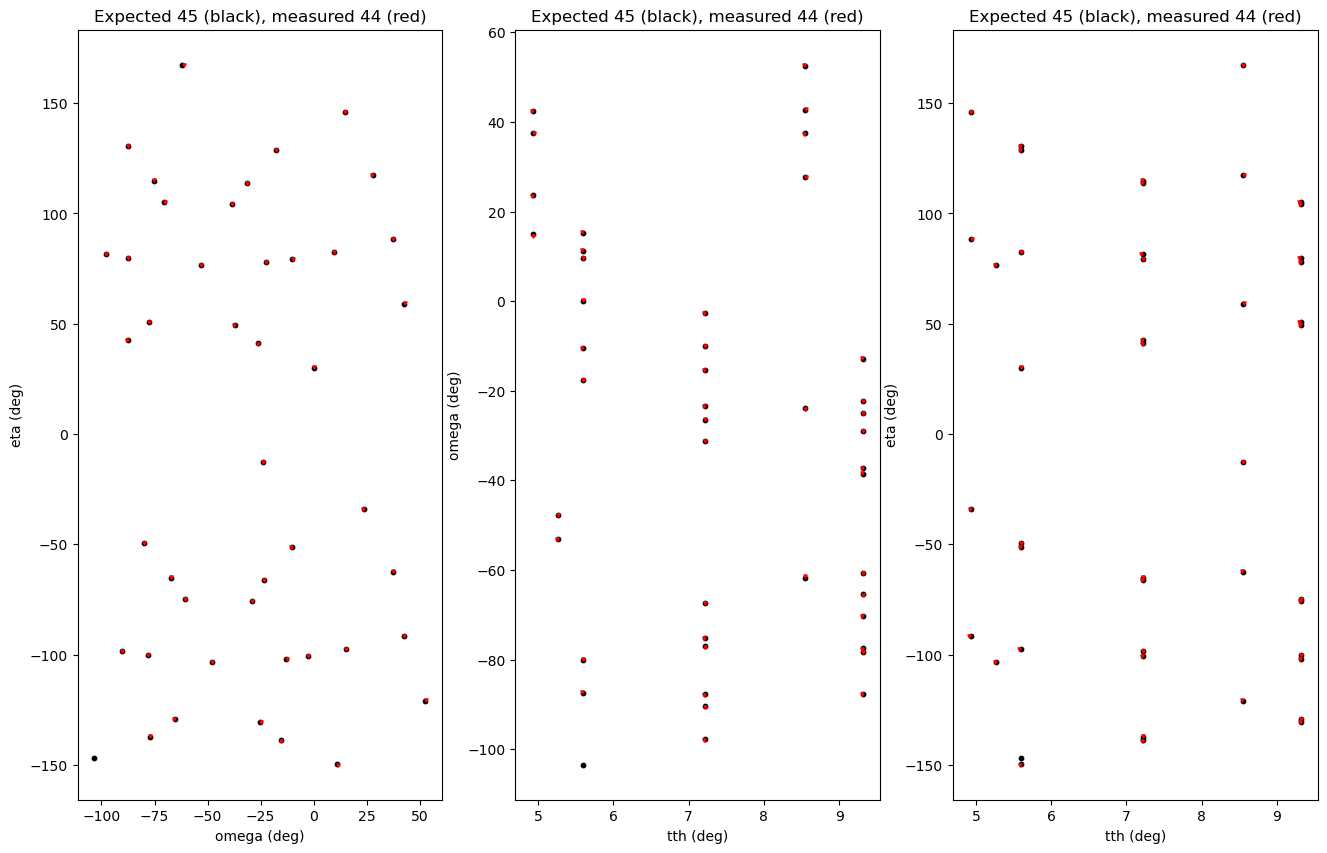

Saved measured vs expected: s000_f002_MgCa_g12_scatter.png
--------------------------------------------------------------

GRAIN 13
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g013_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g013_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g013_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

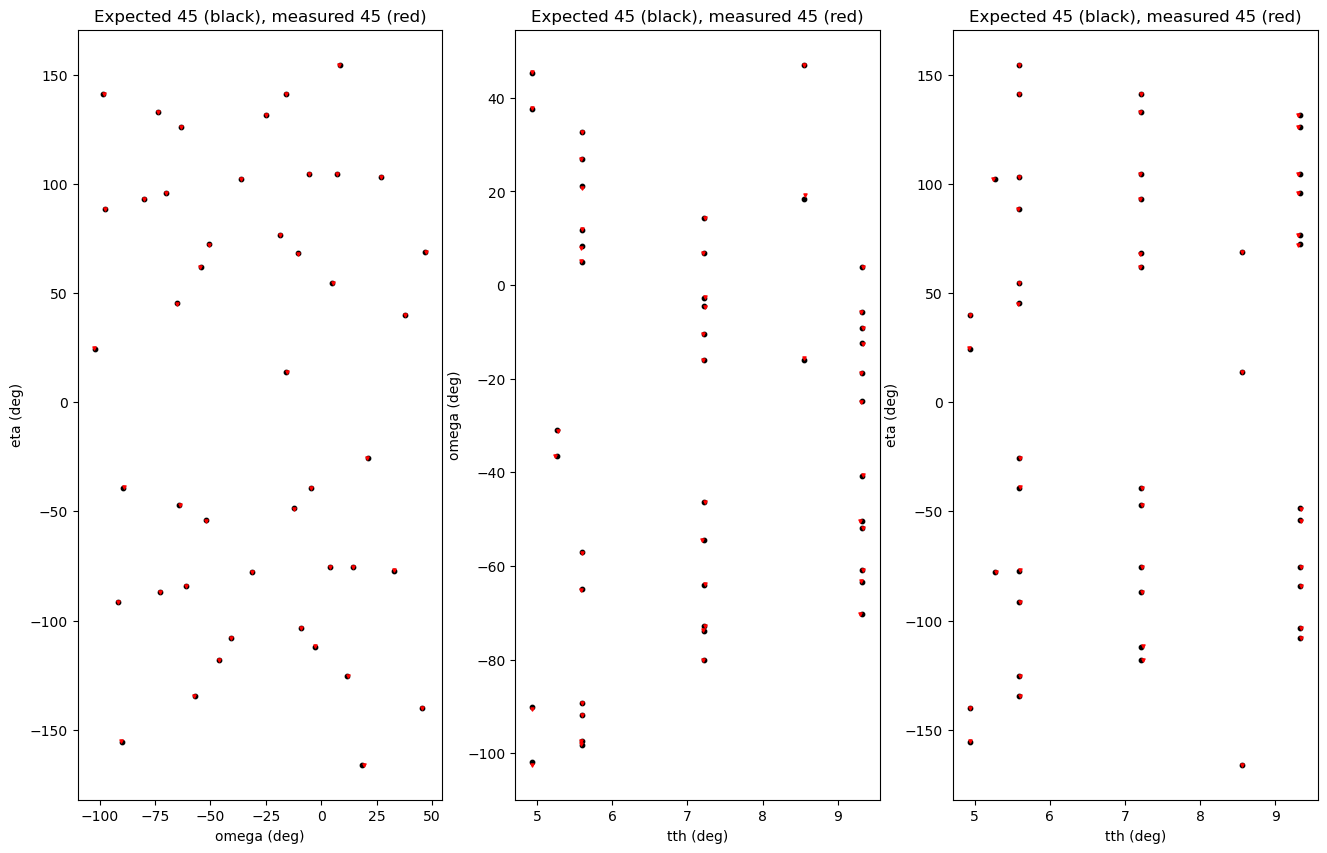

Saved measured vs expected: s000_f002_MgCa_g13_scatter.png
--------------------------------------------------------------

GRAIN 14
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g014_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g014_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g014_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

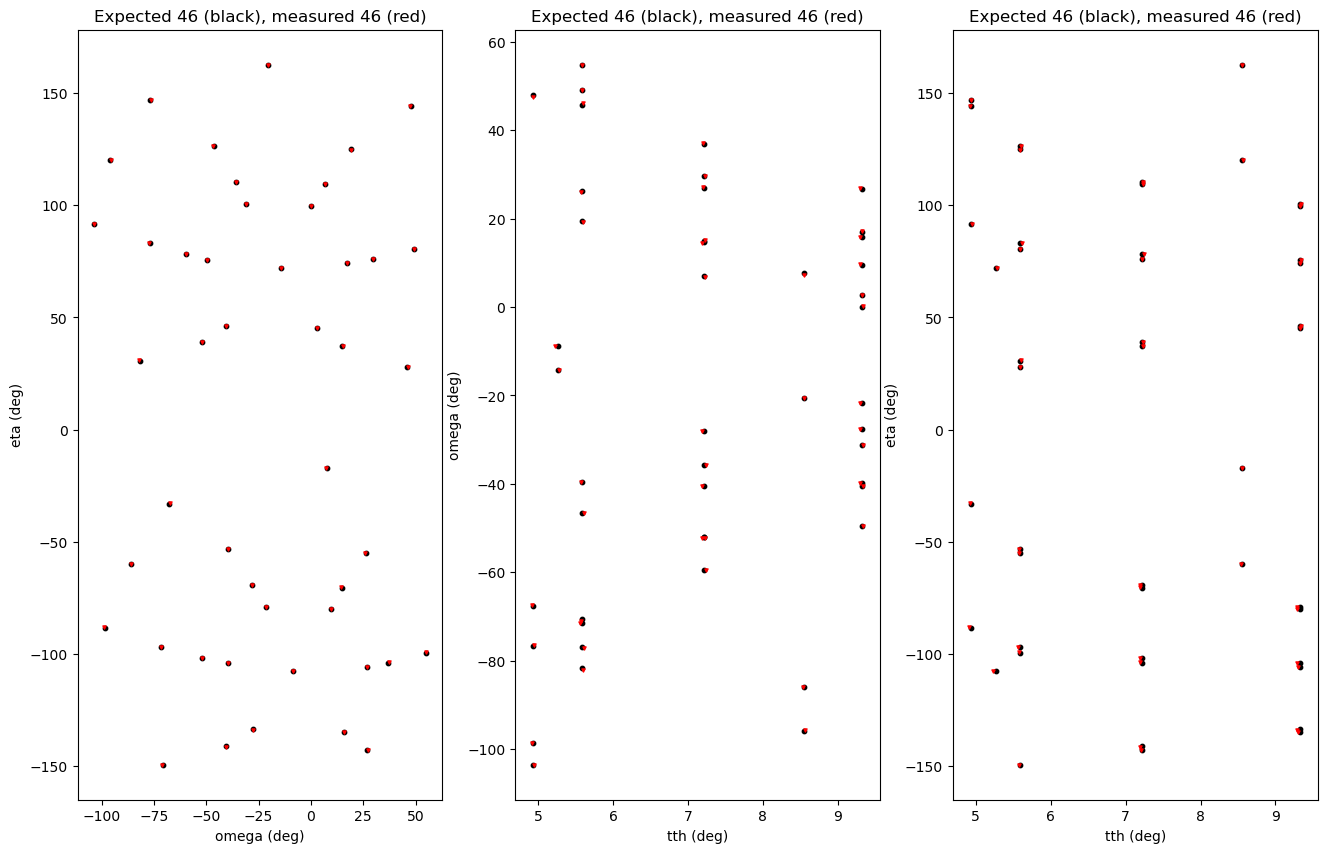

Saved measured vs expected: s000_f002_MgCa_g14_scatter.png
--------------------------------------------------------------

GRAIN 15
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g015_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g015_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g015_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

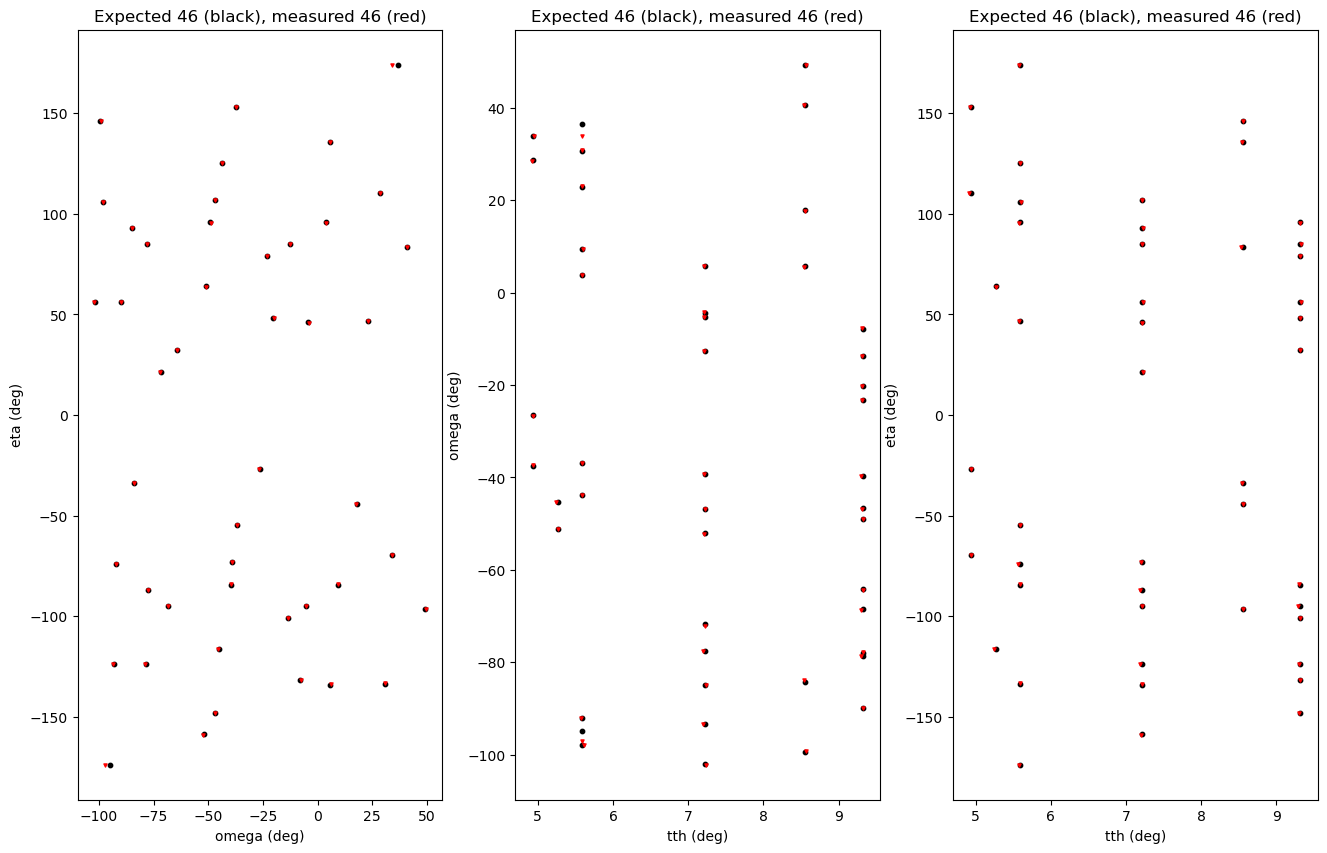

Saved measured vs expected: s000_f002_MgCa_g15_scatter.png
--------------------------------------------------------------

GRAIN 16
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g016_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g016_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g016_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

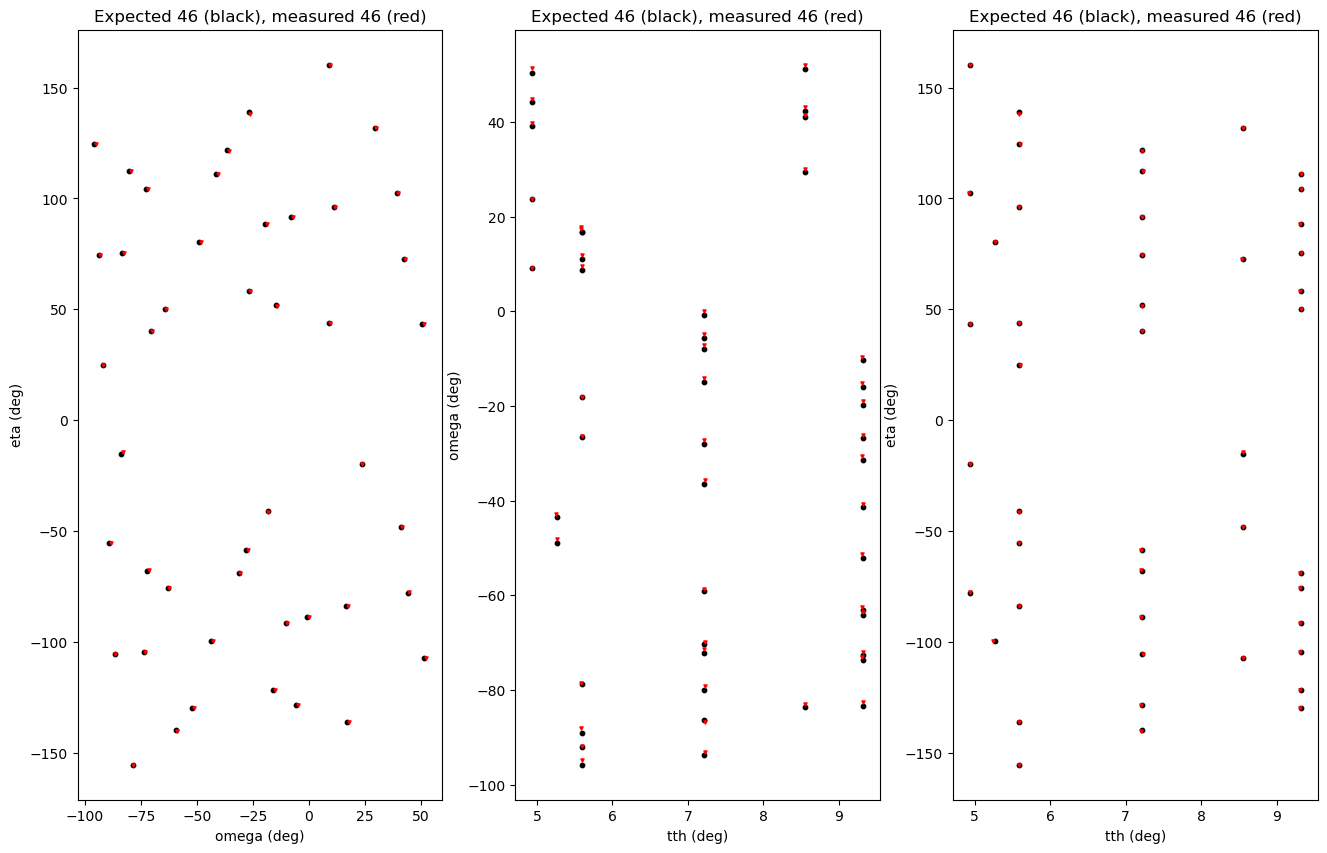

Saved measured vs expected: s000_f002_MgCa_g16_scatter.png
--------------------------------------------------------------

GRAIN 17
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g017_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g017_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g017_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

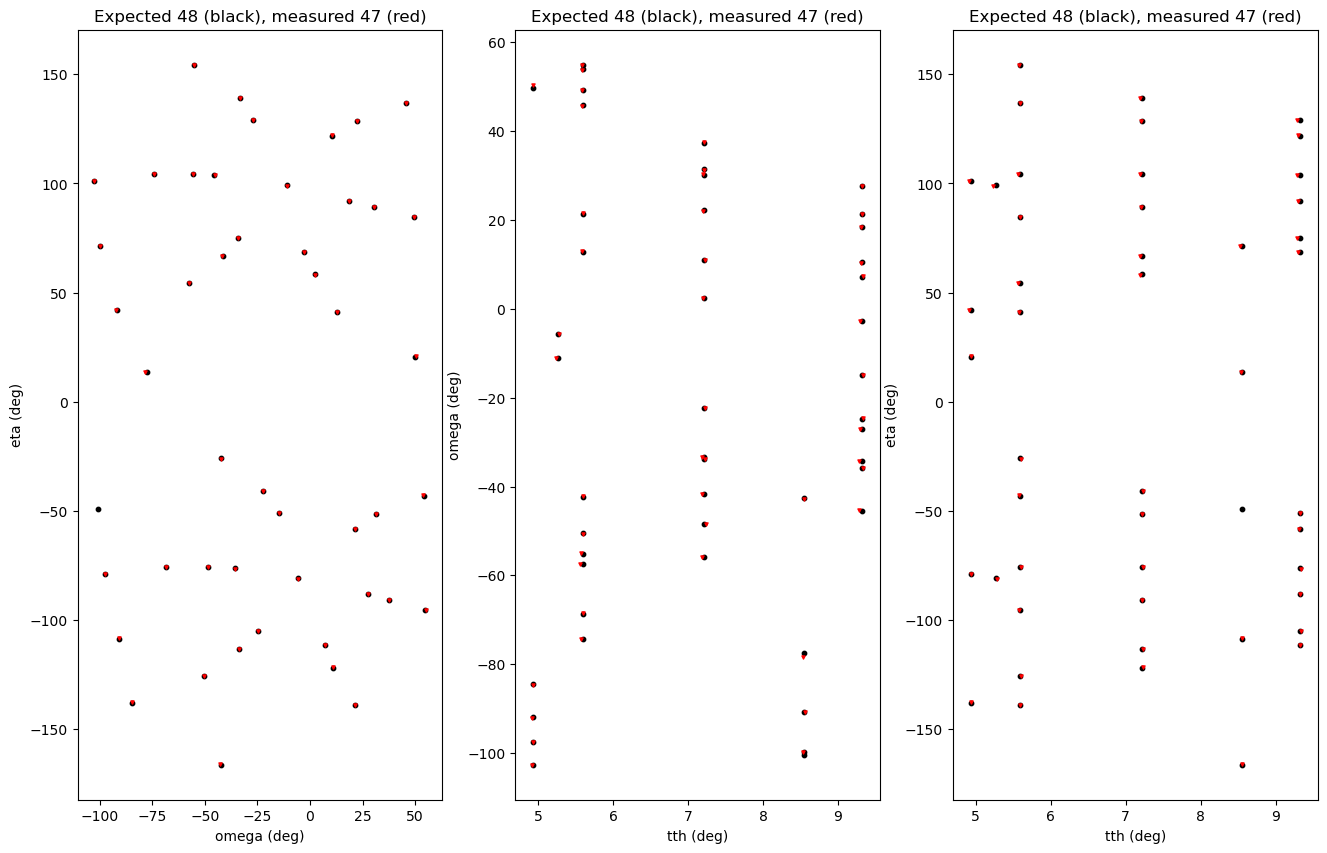

Saved measured vs expected: s000_f002_MgCa_g17_scatter.png
--------------------------------------------------------------

GRAIN 18
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g018_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g018_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g018_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

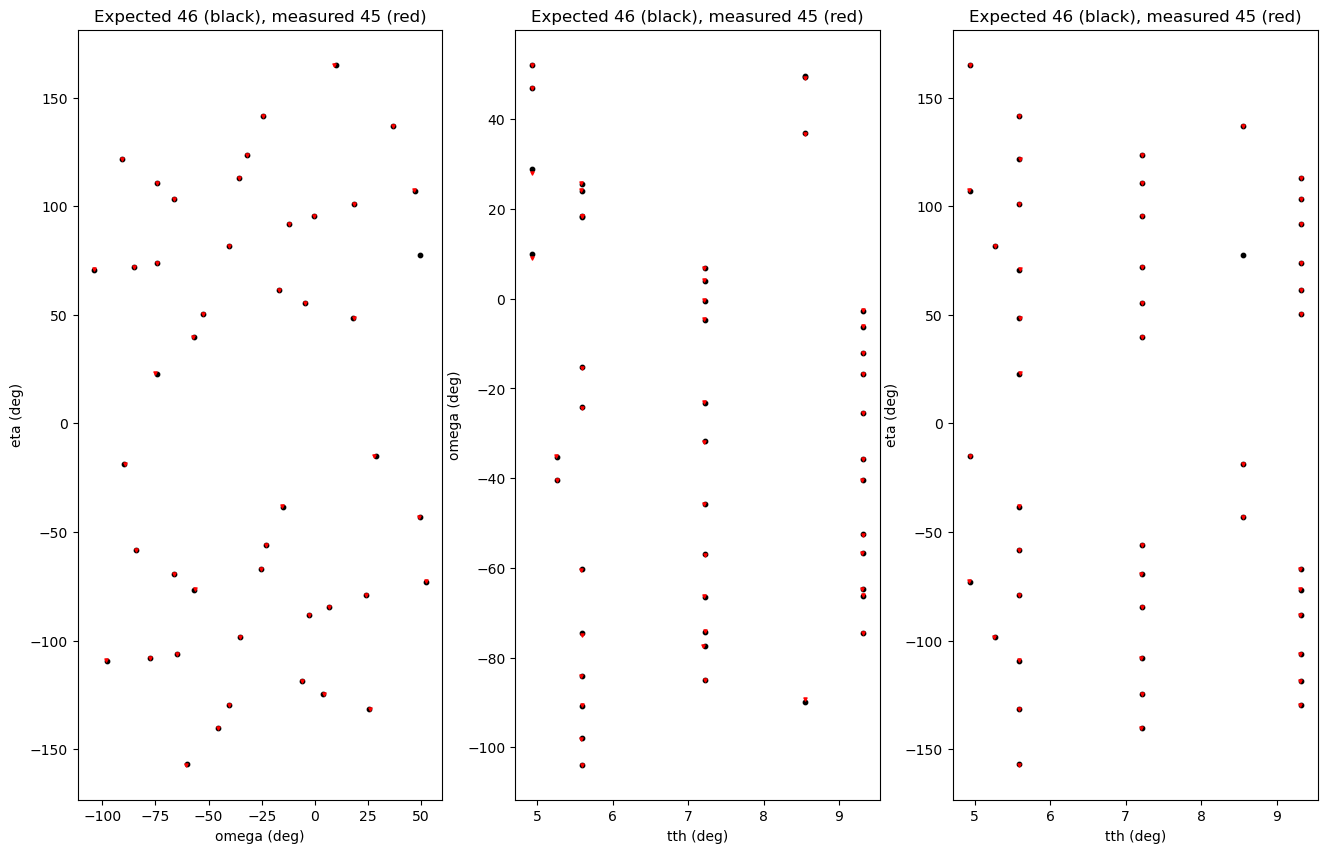

Saved measured vs expected: s000_f002_MgCa_g18_scatter.png
--------------------------------------------------------------

GRAIN 19
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g019_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g019_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g019_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

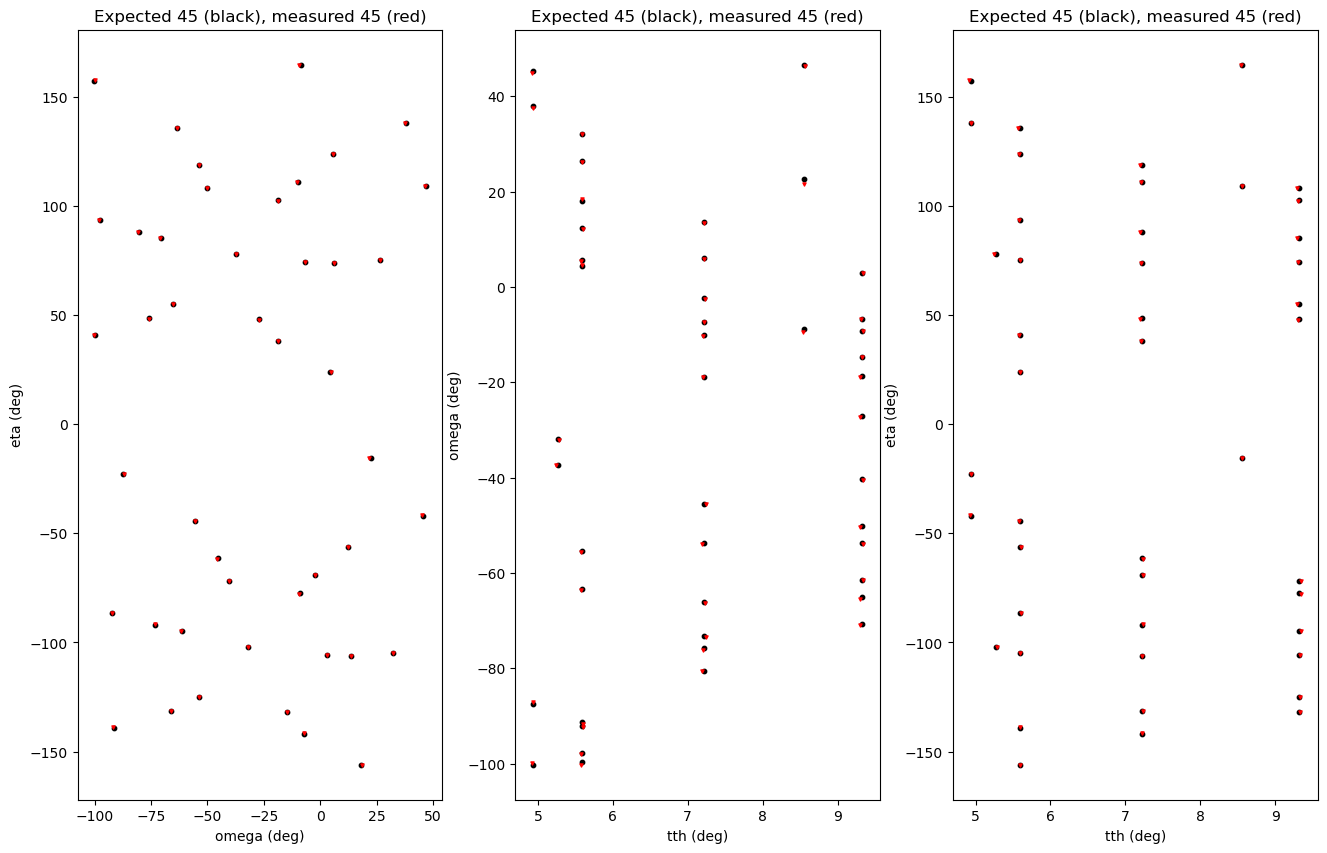

Saved measured vs expected: s000_f002_MgCa_g19_scatter.png
--------------------------------------------------------------

GRAIN 20
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g020_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g020_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g020_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

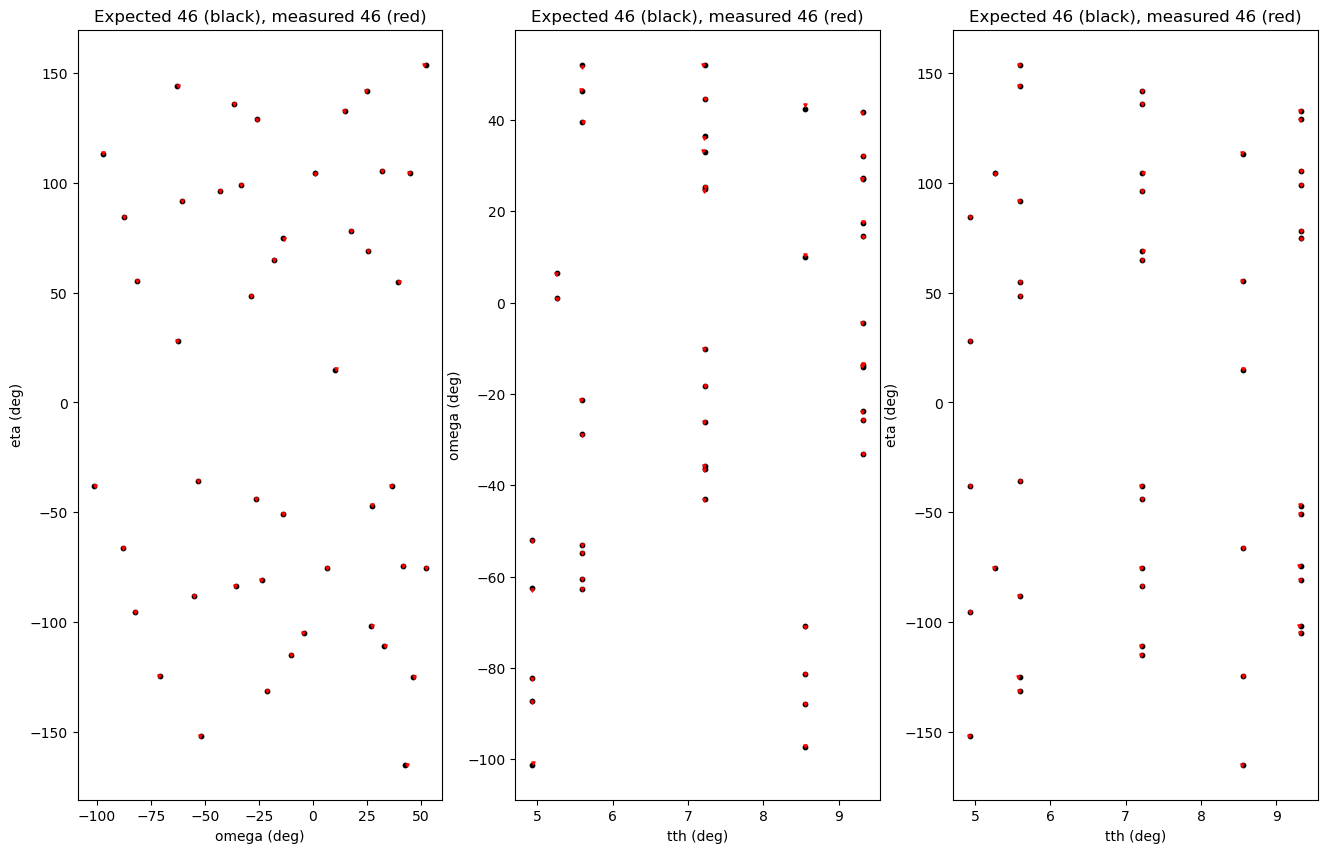

Saved measured vs expected: s000_f002_MgCa_g20_scatter.png
--------------------------------------------------------------

GRAIN 21
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g021_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g021_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g021_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

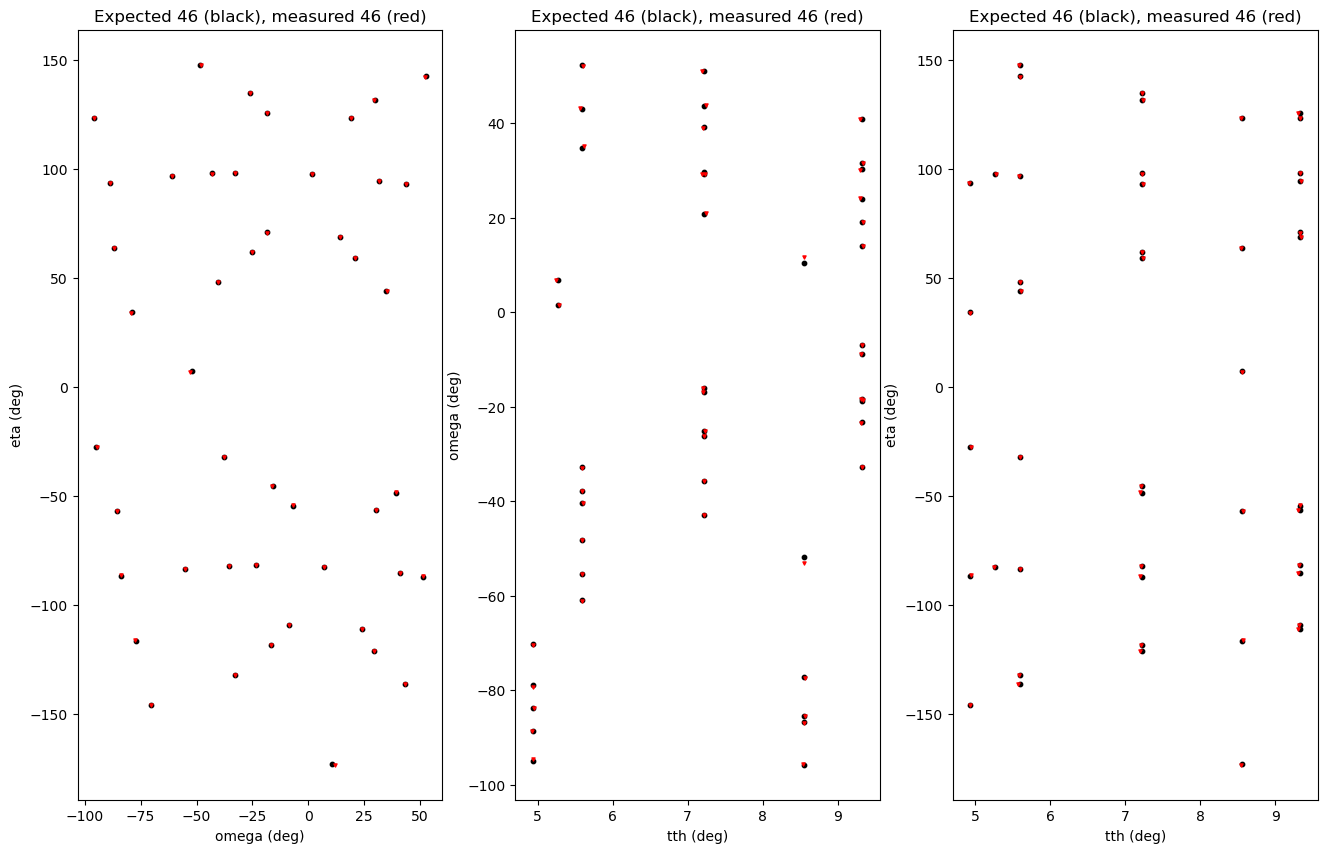

Saved measured vs expected: s000_f002_MgCa_g21_scatter.png
--------------------------------------------------------------

GRAIN 22
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g022_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g022_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g022_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

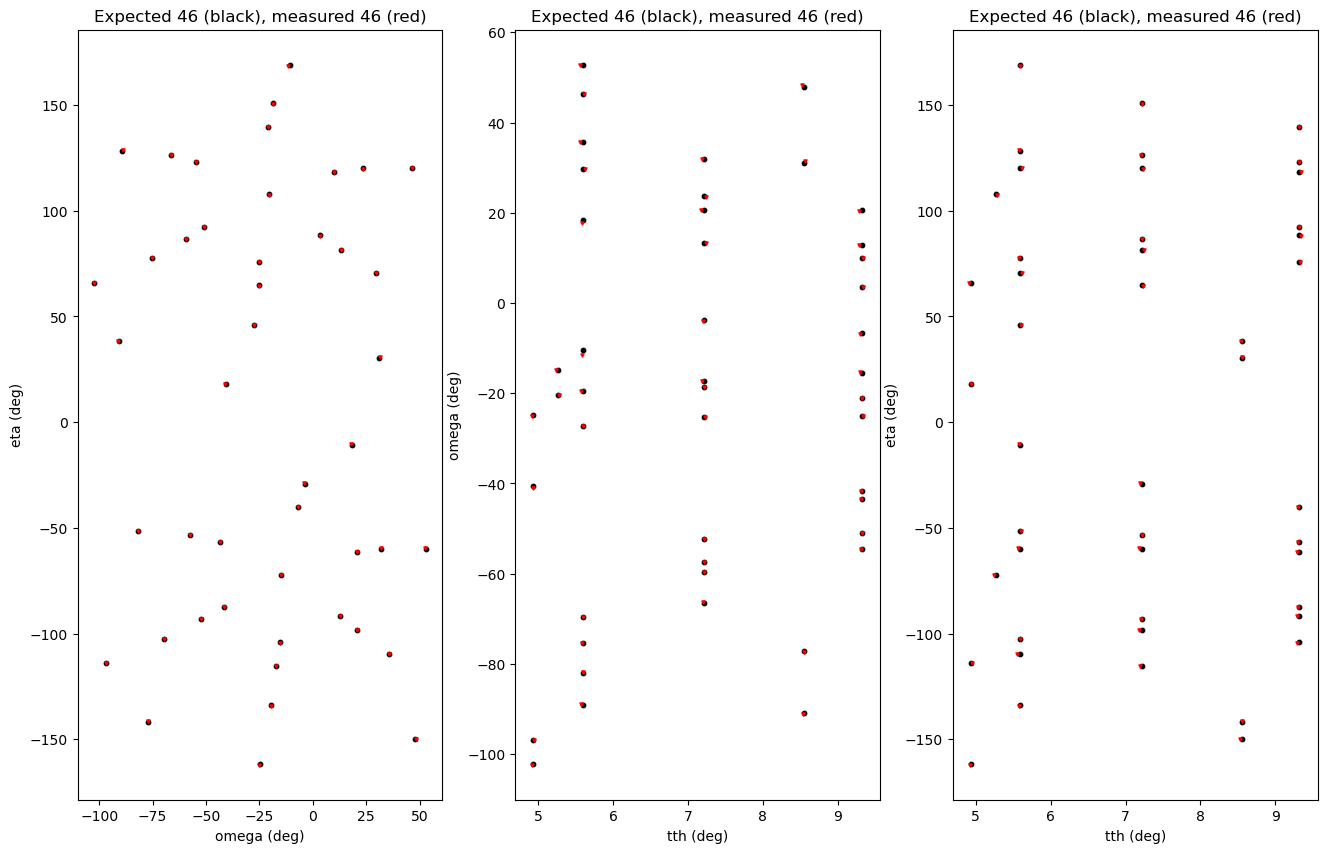

Saved measured vs expected: s000_f002_MgCa_g22_scatter.png
--------------------------------------------------------------

GRAIN 23
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g023_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g023_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g023_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

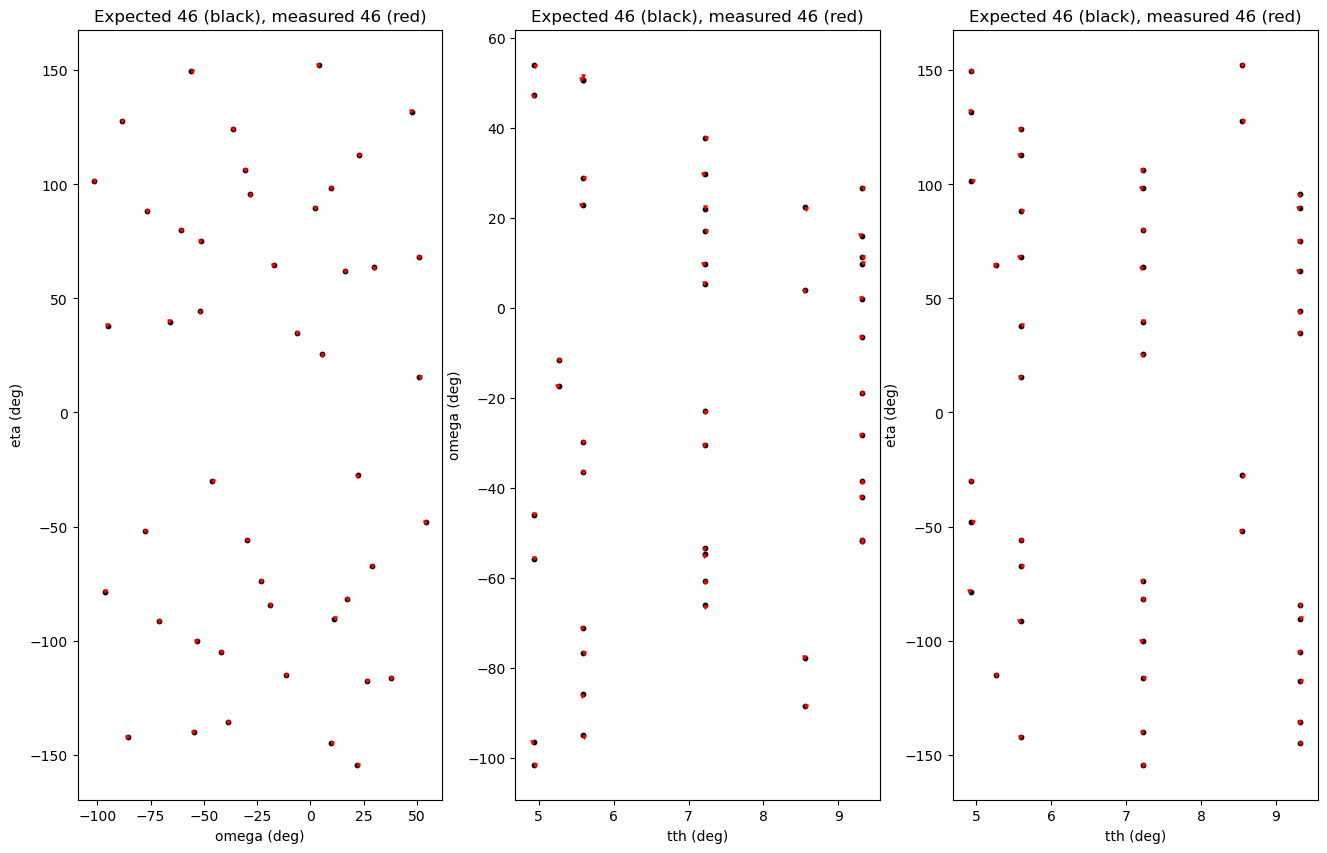

Saved measured vs expected: s000_f002_MgCa_g23_scatter.png
--------------------------------------------------------------

GRAIN 24
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g024_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g024_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g024_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

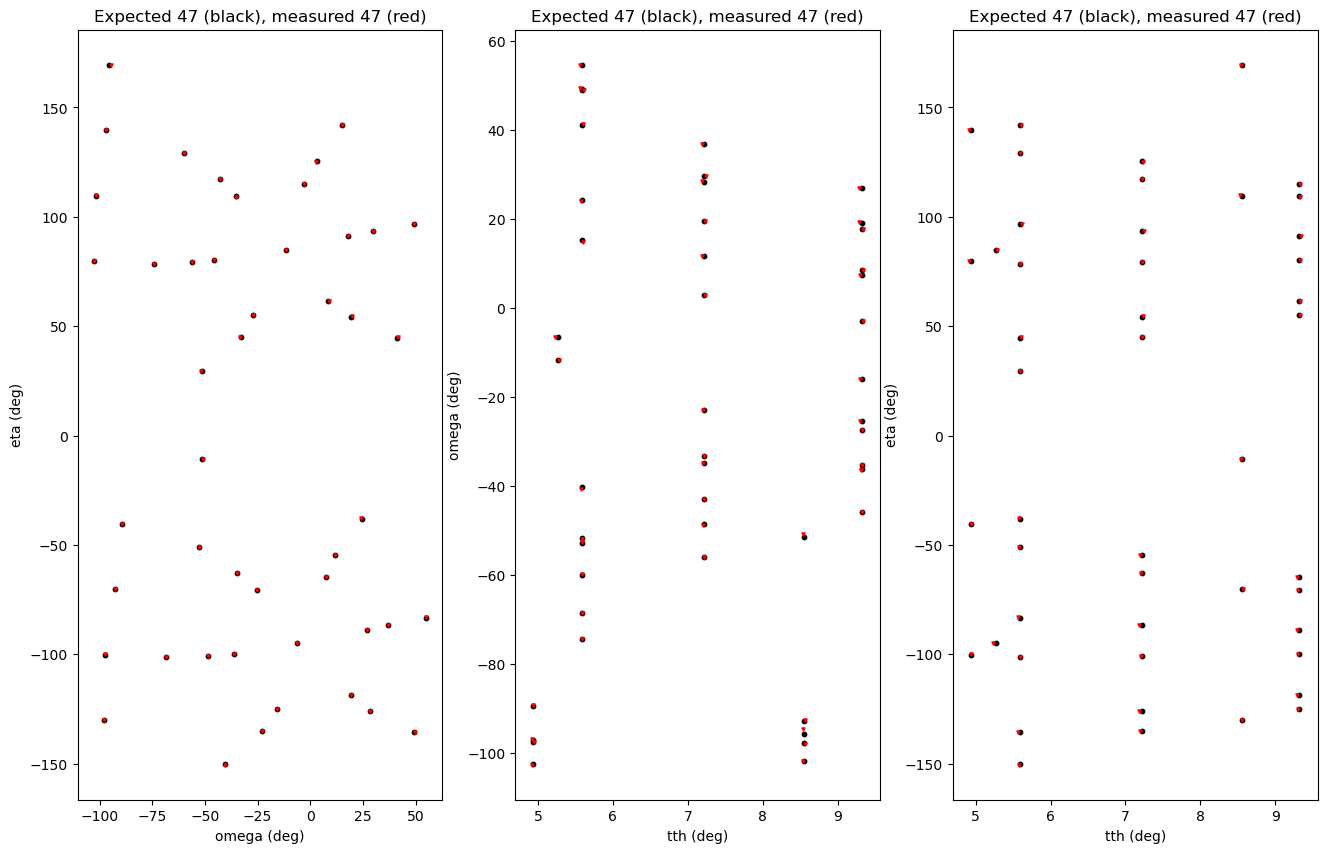

Saved measured vs expected: s000_f002_MgCa_g24_scatter.png
--------------------------------------------------------------

GRAIN 25
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g025_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g025_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g025_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

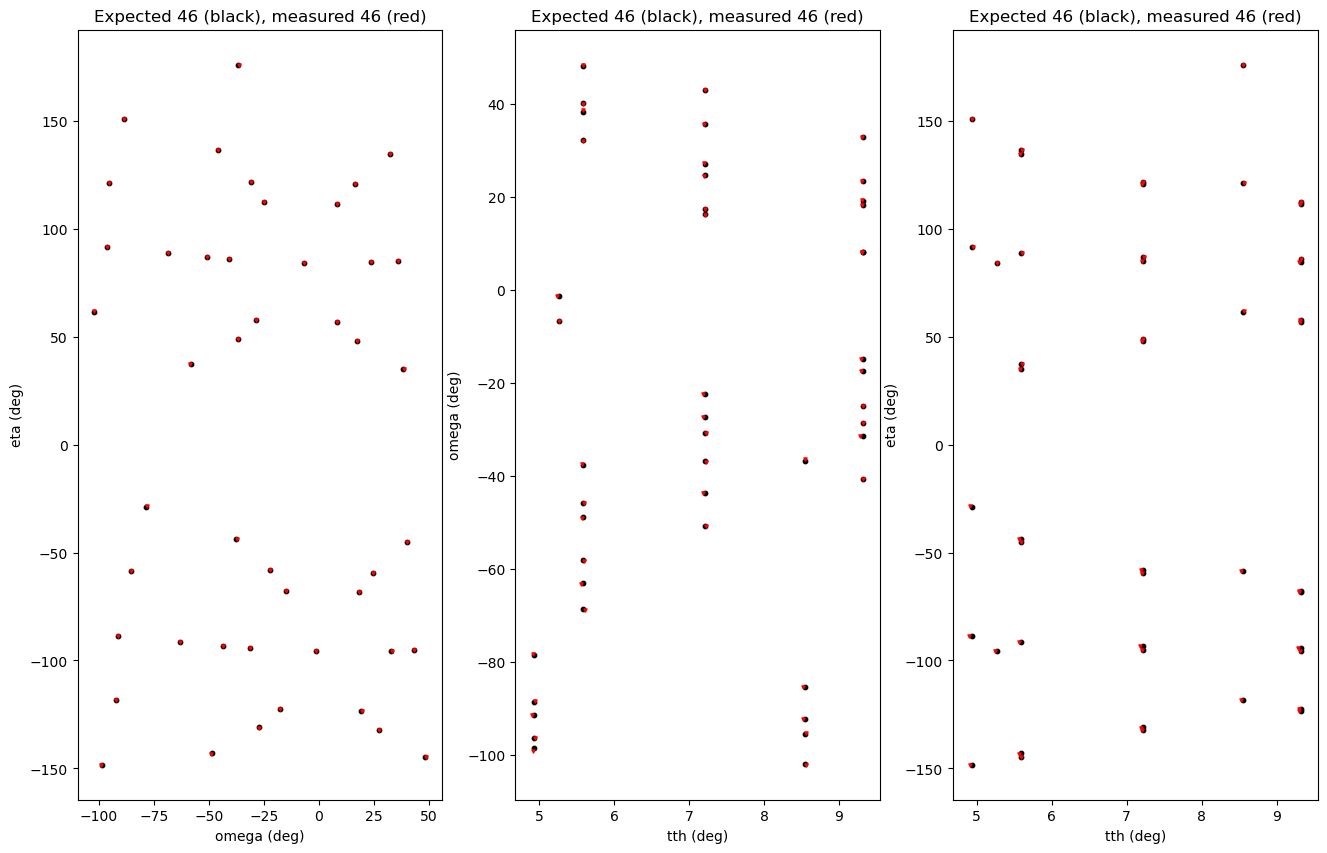

Saved measured vs expected: s000_f002_MgCa_g25_scatter.png
--------------------------------------------------------------

GRAIN 26
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g026_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g026_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g026_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

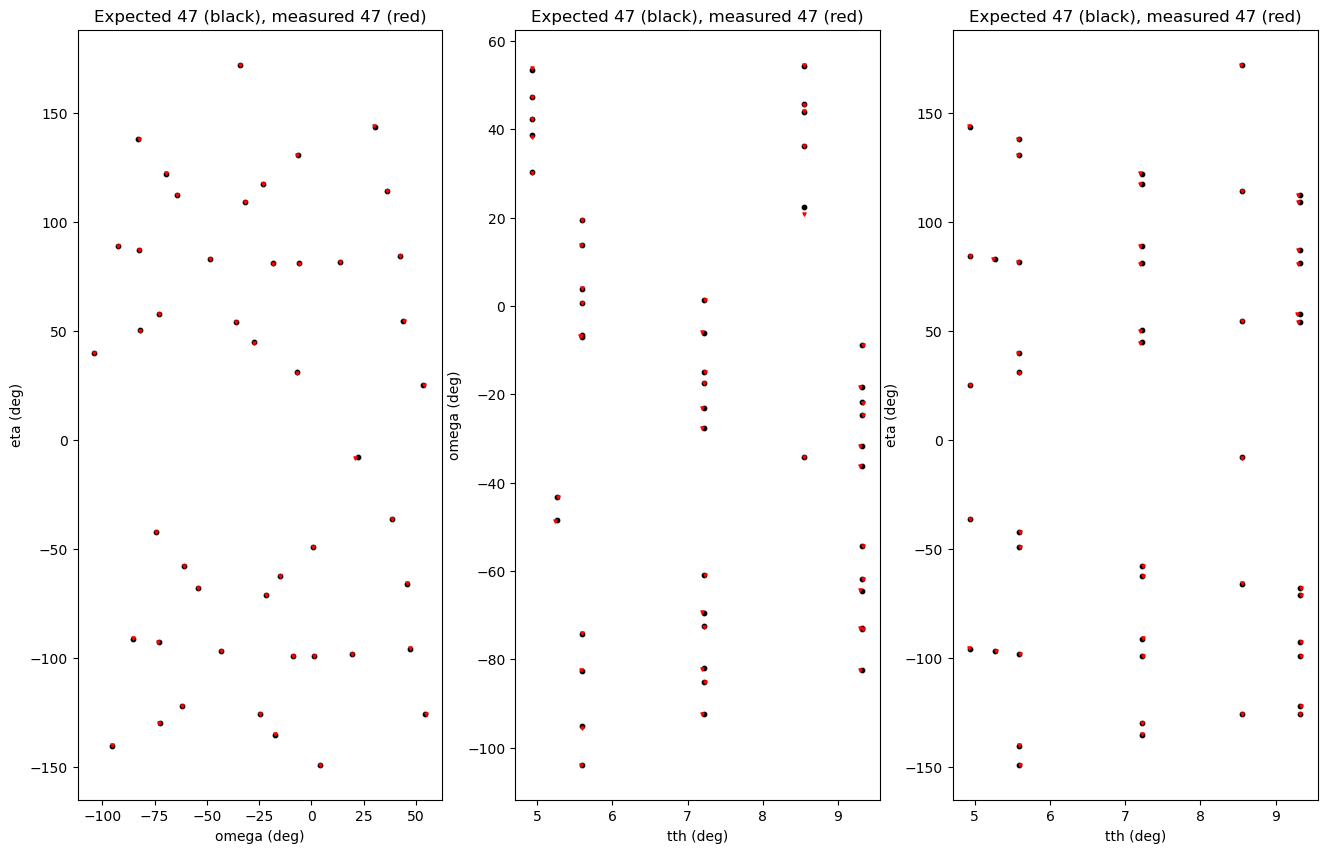

Saved measured vs expected: s000_f002_MgCa_g26_scatter.png
--------------------------------------------------------------

GRAIN 27
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g027_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g027_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g027_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

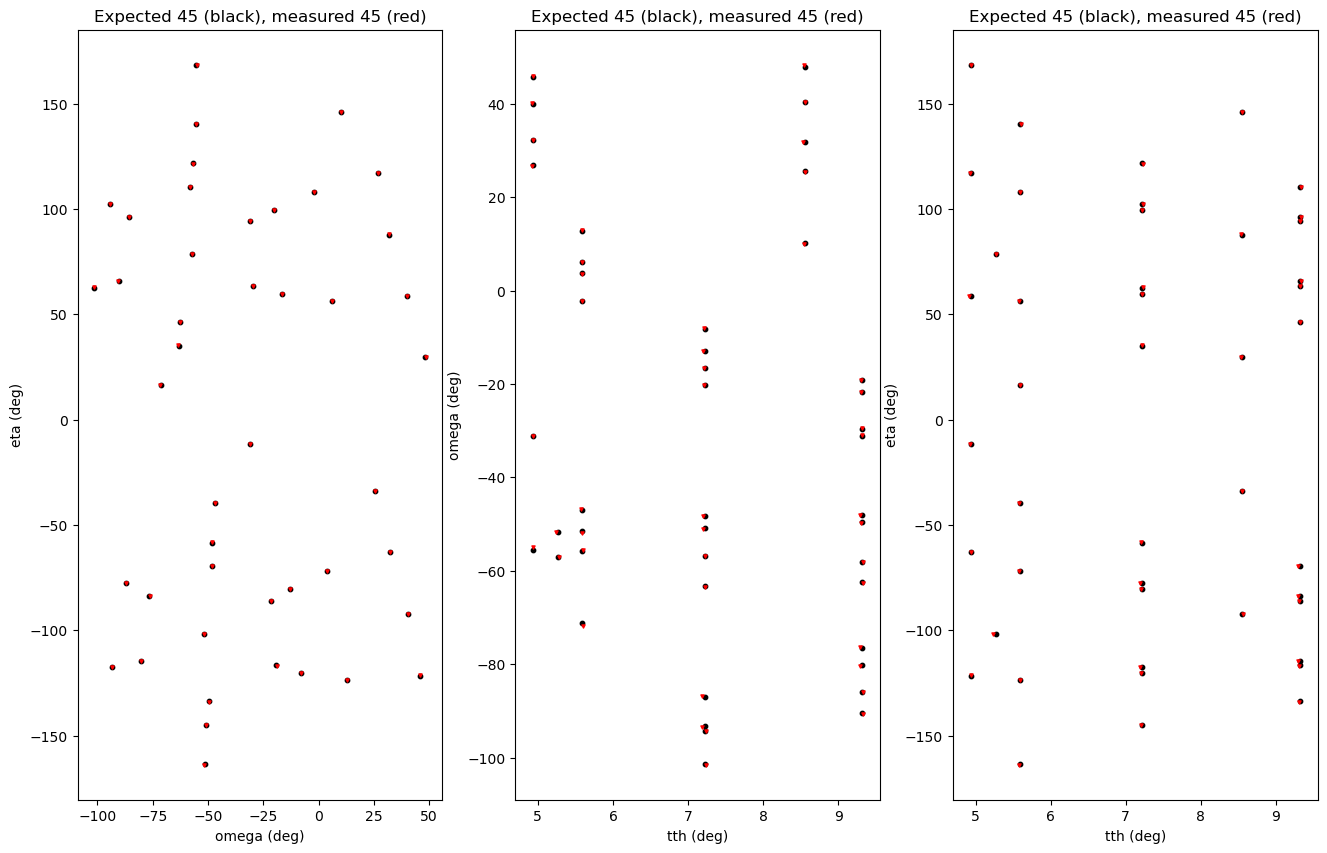

Saved measured vs expected: s000_f002_MgCa_g27_scatter.png
--------------------------------------------------------------

GRAIN 28
Initialized GvectorEvaluator object.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g028_d4.inp
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g028_d4.inp
File already exist!
Overwriting...
Running: PolyXSim.py -i /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_MgCa/sim_g028_d4.inp
Last line in the output:Write g-vector file
Initialized Geometry object.
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/s000_f002_MgCa_sim.par
Geometry object:
directory: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/sim_/
par_file: s000_f002_MgCa_sim.par
yml_file: s000_f0

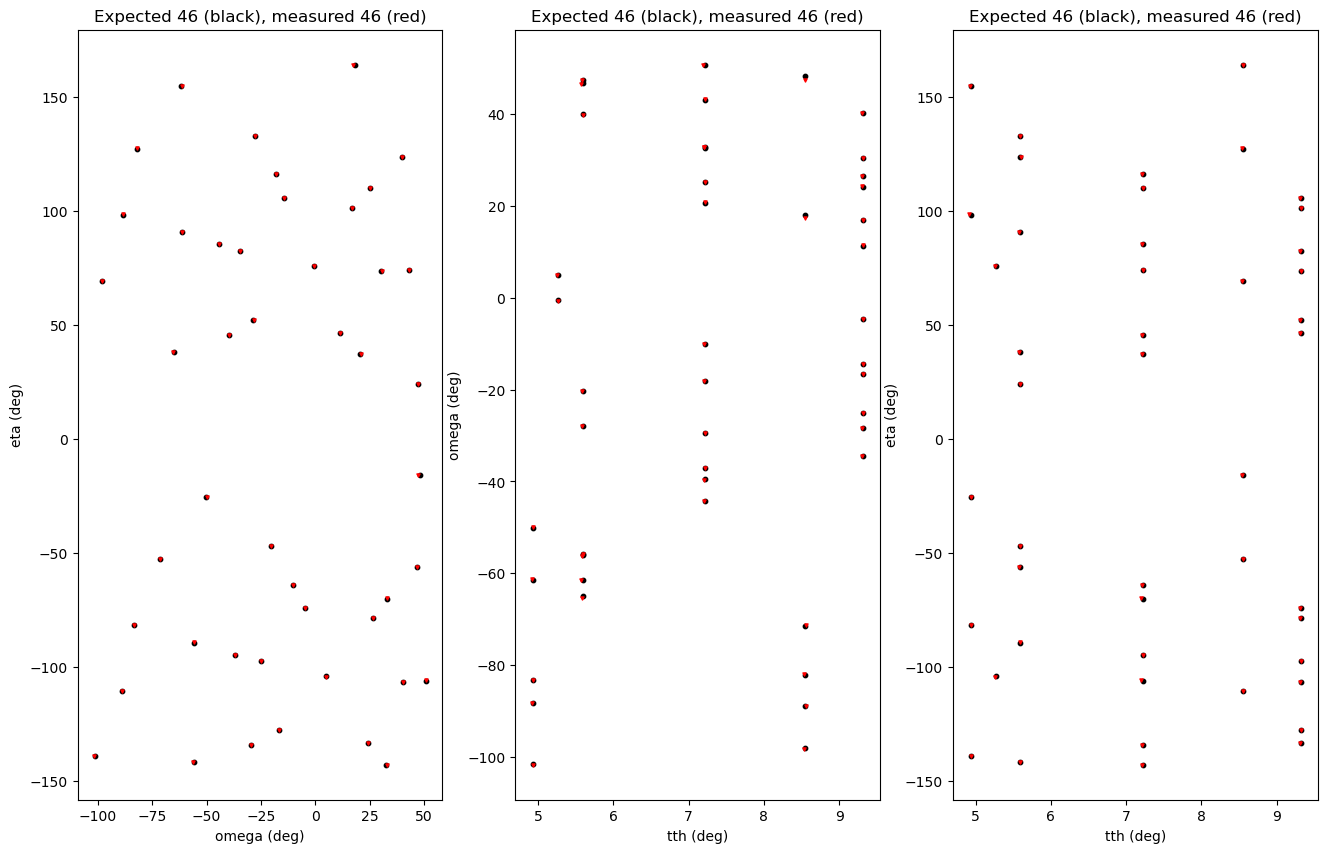

Saved measured vs expected: s000_f002_MgCa_g28_scatter.png
DONE!


In [2]:
### SELECTING WHICH SWEEPS TO ANALYZE:
# loads_str = "1293  1305  1317 1419  1431  1443  1455  1467"
# print(single_separator+'\nLOADS:', [int(v) for v in loads_str.split()].sort())
load_states = [1892, 1904, 1910, 1916, 1922, 1928, 1934, 1940, 1946, 1952, 1958, 1964, 1970, 1976, 1982, 1988, 1994,
               2000, 2006, 2012, 2018, 2024, 2030, 2036, 2042, 2048, 2054, 2060, 2066, 2072, 2078, 2084, 2090] # Indices of loads to analyze
slow_translations = [0]            # Indices of positions to analyze
fast_translations = list(range(6)) # Indices of positions to analyze
detectors         = [4]            # Detector code to analyze (4 for Varex-4 etc)

### LOADING RAW DATA. PEAKSERCHING, MERGING, APPLYING INSTRUMENT CONFIGURATION.
for i_load in load_states[0:1]: # 
    for i_slow in slow_translations[:]:     # (e.g. idty1).
        for i_fast in fast_translations[2:3]: # (e.g. idtz2).
            print(double_separator + f'\nLOAD = {i_load}, TRANSLATIONS: slow = {i_slow}, fast = {i_fast}')
            
            DATA = set_DATA(path_gen, i_load, i_slow, i_fast, detectors, material)
            
            DATA.process_images(frames = 'all', save_tifs = False, q0_pos = 'auto', rad_ranges = 'auto', thr = 'auto')
            DATA.peaksearch(peaksearch_thresholds = 'auto', peakmerge_thresholds = 'auto', min_peak_dist = 10)
            DATA.save_geometries_as_yml()
            pickle.dump(DATA, open(DATA.directory+DATA.name+"_DATA.p","wb") )
            
#             DATA = pickle.load(open(DATA.directory+DATA.name+"_DATA.p","rb") )
            DATA.index() #move_det_xyz_mm = [0, -1*DATA.position[1], 0])
            DATA.evaluateGvectors(tth_gap=0.5, ds_gap=0.1, eta_gap=1)
            DATA.searchGrains(grainSpotter = set_GrainSpotter(path_gen, material))
            pickle.dump(DATA, open(DATA.directory+DATA.name+"_DATA.p","wb") )
            
#             DATA = pickle.load(open(DATA.directory+DATA.name+"_DATA.p","rb") )
            DATA.runPolyXSim(polyxsim = set_PolySim(path_gen, DATA.grainSpotter))
print('DONE!')

In [3]:
DATA.save_geometries_as_yml()

Warning! File already exist!
Overwriting...
Exported all the geometries as .yml file: /asap3/petra3/gpfs/p21.2/2022/data/11012680/processed/Anatoly/newMgAl102/1892/y_0.000_z_6.315/s000_f002_MgCa.yml
